In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

env = gym.make(
        'LunarLander-v2',
        continuous=False,
        gravity=-10,
        enable_wind=False,
        wind_power=20,
        turbulence_power=2
    )

print("Size of State Space ->  {}".format(env.observation_space))
print("Size of Action Space ->  {}".format(env.action_space))
#print("Value of Action ->  {}".format(env.action_space))
#print("Min Value of Action ->  {}".format(env.action_space.low[0]))

Size of State Space ->  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Size of Action Space ->  Discrete(4)


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
env.action_space.sample()

3

In [4]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions, upper_bound, continuous=True, layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(num_actions, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(num_states, num_actions, layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)

    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, num_states, num_actions, lower_bound, upper_bound, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.continuous = continuous

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.critic_model = get_critic(num_states, num_actions, layer1=400, layer2=300)

        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.target_critic = get_critic(num_states, num_actions, layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        # clip gradient to avoid big gradients
        critic_grad =  tf.clip_by_value(critic_grad, clip_value_min=-1, clip_value_max=1)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        critic_grad =  tf.clip_by_value(actor_grad, clip_value_min=-1, clip_value_max=1)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        # Add done_batch for terminal state
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
            
        if self.continuous:
            return [np.squeeze(legal_action)]
        else:
            clip_disc = max(0, int(np.squeeze(legal_action)))
            clip_disc = min(3, clip_disc)
            return clip_disc

In [6]:
def fixed(x, episode):
    return x

In [7]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        
        # Stepcount for random start
        step = 0

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                    # To get the right format
                    if continuous:
                        action = action[0]
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground
                terminal_state = state[6] and state[7]
                
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            avg_reward_list[trial].append(avg_reward)
            
            # stop if avg is solved
            if true_avg_reward >= solved:
                break

        # Save weights naming
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power, 
            turbulence_power, timestamp
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [8]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
        # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)
            if continuous:
                action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [9]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [24]:
xax = [x for x in range(-600,200)]

In [25]:
def decreasing_std(x, episode):
    return x/(1+(episode/500))

In [26]:
def decreasing_lr(x, episode):
    return x/(1+(episode/500))

In [27]:
def decreasing_std(x, episode):
    return abs(min(1.5,(0.7/(0.005*max(x+400,1)))))

In [28]:
print(decreasing_std(-900,1))

1.5


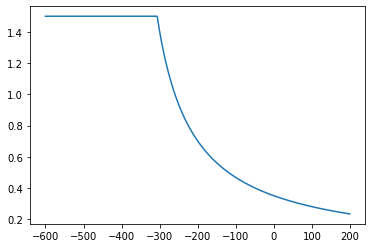

In [30]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,200)])

Ep 0 * AvgReward -76.00 * true AvgReward -76.00 * Reward -76.00 * True Reward -76.00 * time 2.01 * step 123
Ep 1 * AvgReward -96.80 * true AvgReward -96.80 * Reward -117.59 * True Reward -117.59 * time 1.13 * step 228
Ep 2 * AvgReward -119.74 * true AvgReward -119.74 * Reward -165.64 * True Reward -165.64 * time 1.42 * step 360
Ep 3 * AvgReward -216.65 * true AvgReward -216.65 * Reward -507.39 * True Reward -507.39 * time 1.49 * step 488
Ep 4 * AvgReward -216.76 * true AvgReward -216.76 * Reward -217.17 * True Reward -217.17 * time 1.04 * step 586
Ep 5 * AvgReward -205.89 * true AvgReward -205.89 * Reward -151.53 * True Reward -151.53 * time 1.07 * step 683
Ep 6 * AvgReward -186.25 * true AvgReward -186.25 * Reward -68.45 * True Reward -68.45 * time 1.06 * step 770
Ep 7 * AvgReward -186.43 * true AvgReward -186.43 * Reward -187.67 * True Reward -187.67 * time 1.12 * step 869
Ep 8 * AvgReward -193.37 * true AvgReward -193.37 * Reward -248.85 * True Reward -248.85 * time 1.04 * step 957


Ep 73 * AvgReward -202.88 * true AvgReward -202.88 * Reward -208.75 * True Reward -208.75 * time 0.75 * step 6937
Ep 74 * AvgReward -216.35 * true AvgReward -216.35 * Reward -382.91 * True Reward -382.91 * time 1.18 * step 7040
Ep 75 * AvgReward -224.54 * true AvgReward -224.54 * Reward -430.17 * True Reward -430.17 * time 1.16 * step 7142
Ep 76 * AvgReward -223.69 * true AvgReward -223.69 * Reward -100.45 * True Reward -100.45 * time 1.41 * step 7262
Ep 77 * AvgReward -218.84 * true AvgReward -218.84 * Reward -44.57 * True Reward -44.57 * time 1.42 * step 7375
Ep 78 * AvgReward -223.67 * true AvgReward -223.67 * Reward -194.33 * True Reward -194.33 * time 0.81 * step 7440
Ep 79 * AvgReward -209.75 * true AvgReward -209.75 * Reward -81.15 * True Reward -81.15 * time 0.62 * step 7502
Ep 80 * AvgReward -206.61 * true AvgReward -206.61 * Reward -74.72 * True Reward -74.72 * time 0.76 * step 7568
Ep 81 * AvgReward -188.83 * true AvgReward -188.83 * Reward 33.05 * True Reward 33.05 * time 1

Ep 145 * AvgReward -177.89 * true AvgReward -177.89 * Reward -125.97 * True Reward -125.97 * time 1.38 * step 13514
Ep 146 * AvgReward -193.21 * true AvgReward -193.21 * Reward -471.95 * True Reward -471.95 * time 1.24 * step 13630
Ep 147 * AvgReward -193.18 * true AvgReward -193.18 * Reward -62.27 * True Reward -62.27 * time 0.84 * step 13705
Ep 148 * AvgReward -200.97 * true AvgReward -200.97 * Reward -236.95 * True Reward -236.95 * time 0.94 * step 13782
Ep 149 * AvgReward -190.35 * true AvgReward -190.35 * Reward -144.34 * True Reward -144.34 * time 1.35 * step 13901
Ep 150 * AvgReward -198.76 * true AvgReward -198.76 * Reward -415.33 * True Reward -415.33 * time 1.29 * step 14010
Ep 151 * AvgReward -200.97 * true AvgReward -200.97 * Reward -170.84 * True Reward -170.84 * time 1.07 * step 14106
Ep 152 * AvgReward -203.18 * true AvgReward -203.18 * Reward -124.66 * True Reward -124.66 * time 1.22 * step 14217
Ep 153 * AvgReward -205.70 * true AvgReward -205.70 * Reward -124.15 * Tru

Ep 216 * AvgReward -190.49 * true AvgReward -190.49 * Reward 62.13 * True Reward 62.13 * time 12.45 * step 20917
Ep 217 * AvgReward -196.04 * true AvgReward -196.04 * Reward -237.66 * True Reward -237.66 * time 0.85 * step 21004
Ep 218 * AvgReward -193.45 * true AvgReward -193.45 * Reward -74.00 * True Reward -74.00 * time 0.70 * step 21082
Ep 219 * AvgReward -184.32 * true AvgReward -184.32 * Reward -111.65 * True Reward -111.65 * time 0.96 * step 21170
Ep 220 * AvgReward -175.50 * true AvgReward -175.50 * Reward -97.52 * True Reward -97.52 * time 0.92 * step 21261
Ep 221 * AvgReward -176.25 * true AvgReward -176.25 * Reward -110.86 * True Reward -110.86 * time 0.71 * step 21321
Ep 222 * AvgReward -166.31 * true AvgReward -166.31 * Reward -187.95 * True Reward -187.95 * time 1.47 * step 21446
Ep 223 * AvgReward -168.00 * true AvgReward -168.00 * Reward -108.62 * True Reward -108.62 * time 0.87 * step 21515
Ep 224 * AvgReward -161.48 * true AvgReward -161.48 * Reward -63.33 * True Rewa

Ep 287 * AvgReward -228.25 * true AvgReward -228.25 * Reward -190.02 * True Reward -190.02 * time 1.60 * step 27540
Ep 288 * AvgReward -236.25 * true AvgReward -236.25 * Reward -298.26 * True Reward -298.26 * time 1.28 * step 27668
Ep 289 * AvgReward -235.18 * true AvgReward -235.18 * Reward -83.82 * True Reward -83.82 * time 1.20 * step 27780
Ep 290 * AvgReward -221.13 * true AvgReward -221.13 * Reward -6.13 * True Reward -6.13 * time 0.80 * step 27861
Ep 291 * AvgReward -215.45 * true AvgReward -215.45 * Reward -114.83 * True Reward -114.83 * time 0.94 * step 27942
Ep 292 * AvgReward -205.49 * true AvgReward -205.49 * Reward -125.72 * True Reward -125.72 * time 1.51 * step 28075
Ep 293 * AvgReward -222.58 * true AvgReward -222.58 * Reward -408.73 * True Reward -408.73 * time 1.11 * step 28171
Ep 294 * AvgReward -214.29 * true AvgReward -214.29 * Reward -139.11 * True Reward -139.11 * time 1.09 * step 28277
Ep 295 * AvgReward -211.86 * true AvgReward -211.86 * Reward -308.92 * True Re

Ep 358 * AvgReward -118.56 * true AvgReward -118.56 * Reward -119.37 * True Reward -119.37 * time 0.73 * step 33416
Ep 359 * AvgReward -115.94 * true AvgReward -115.94 * Reward -106.30 * True Reward -106.30 * time 0.85 * step 33474
Ep 360 * AvgReward -127.29 * true AvgReward -127.29 * Reward -211.28 * True Reward -211.28 * time 1.25 * step 33553
Ep 361 * AvgReward -121.80 * true AvgReward -121.80 * Reward -38.23 * True Reward -38.23 * time 1.12 * step 33637
Ep 362 * AvgReward -119.49 * true AvgReward -119.49 * Reward -94.95 * True Reward -94.95 * time 0.70 * step 33692
Ep 363 * AvgReward -120.50 * true AvgReward -120.50 * Reward -168.17 * True Reward -168.17 * time 1.09 * step 33773
Ep 364 * AvgReward -134.26 * true AvgReward -134.26 * Reward -360.80 * True Reward -360.80 * time 0.65 * step 33824
Ep 365 * AvgReward -157.30 * true AvgReward -157.30 * Reward -586.90 * True Reward -586.90 * time 0.82 * step 33887
Ep 366 * AvgReward -154.32 * true AvgReward -154.32 * Reward -135.07 * True 

Ep 429 * AvgReward -288.44 * true AvgReward -288.44 * Reward -104.63 * True Reward -104.63 * time 1.08 * step 37941
Ep 430 * AvgReward -258.45 * true AvgReward -258.45 * Reward -186.18 * True Reward -186.18 * time 1.02 * step 38022
Ep 431 * AvgReward -242.06 * true AvgReward -242.06 * Reward -121.79 * True Reward -121.79 * time 0.91 * step 38090
Ep 432 * AvgReward -220.54 * true AvgReward -220.54 * Reward -121.49 * True Reward -121.49 * time 0.93 * step 38162
Ep 433 * AvgReward -203.89 * true AvgReward -203.89 * Reward -105.65 * True Reward -105.65 * time 1.03 * step 38241
Ep 434 * AvgReward -206.20 * true AvgReward -206.20 * Reward -160.97 * True Reward -160.97 * time 0.86 * step 38310
Ep 435 * AvgReward -205.75 * true AvgReward -205.75 * Reward -131.47 * True Reward -131.47 * time 0.85 * step 38372
Ep 436 * AvgReward -202.61 * true AvgReward -202.61 * Reward -97.41 * True Reward -97.41 * time 0.67 * step 38426
Ep 437 * AvgReward -192.09 * true AvgReward -192.09 * Reward -155.11 * Tru

Ep 500 * AvgReward -539.34 * true AvgReward -539.34 * Reward -582.55 * True Reward -582.55 * time 1.48 * step 42710
Ep 501 * AvgReward -540.06 * true AvgReward -540.06 * Reward -440.00 * True Reward -440.00 * time 1.14 * step 42788
Ep 502 * AvgReward -540.08 * true AvgReward -540.08 * Reward -533.23 * True Reward -533.23 * time 0.86 * step 42847
Ep 503 * AvgReward -557.99 * true AvgReward -557.99 * Reward -779.01 * True Reward -779.01 * time 1.05 * step 42924
Ep 504 * AvgReward -544.56 * true AvgReward -544.56 * Reward -596.76 * True Reward -596.76 * time 1.00 * step 42993
Ep 505 * AvgReward -542.77 * true AvgReward -542.77 * Reward -451.20 * True Reward -451.20 * time 0.60 * step 43046
Ep 506 * AvgReward -559.45 * true AvgReward -559.45 * Reward -793.05 * True Reward -793.05 * time 1.22 * step 43123
Ep 507 * AvgReward -554.55 * true AvgReward -554.55 * Reward -387.21 * True Reward -387.21 * time 0.76 * step 43182
Ep 508 * AvgReward -524.64 * true AvgReward -524.64 * Reward -170.93 * T

Ep 571 * AvgReward -298.02 * true AvgReward -298.02 * Reward -146.94 * True Reward -146.94 * time 1.05 * step 47350
Ep 572 * AvgReward -277.77 * true AvgReward -277.77 * Reward -164.67 * True Reward -164.67 * time 1.13 * step 47438
Ep 573 * AvgReward -259.04 * true AvgReward -259.04 * Reward -123.13 * True Reward -123.13 * time 0.98 * step 47509
Ep 574 * AvgReward -239.84 * true AvgReward -239.84 * Reward -136.48 * True Reward -136.48 * time 0.82 * step 47569
Ep 575 * AvgReward -216.54 * true AvgReward -216.54 * Reward -167.57 * True Reward -167.57 * time 1.04 * step 47654
Ep 576 * AvgReward -196.23 * true AvgReward -196.23 * Reward -186.43 * True Reward -186.43 * time 0.93 * step 47722
Ep 577 * AvgReward -171.61 * true AvgReward -171.61 * Reward -45.78 * True Reward -45.78 * time 1.37 * step 47817
Ep 578 * AvgReward -165.78 * true AvgReward -165.78 * Reward -276.83 * True Reward -276.83 * time 1.31 * step 47917
Ep 579 * AvgReward -158.61 * true AvgReward -158.61 * Reward 10.97 * True 

Ep 642 * AvgReward -322.56 * true AvgReward -322.56 * Reward -809.72 * True Reward -809.72 * time 1.20 * step 52404
Ep 643 * AvgReward -352.43 * true AvgReward -352.43 * Reward -713.24 * True Reward -713.24 * time 1.07 * step 52485
Ep 644 * AvgReward -380.03 * true AvgReward -380.03 * Reward -710.94 * True Reward -710.94 * time 1.06 * step 52565
Ep 645 * AvgReward -394.99 * true AvgReward -394.99 * Reward -450.47 * True Reward -450.47 * time 0.64 * step 52618
Ep 646 * AvgReward -437.27 * true AvgReward -437.27 * Reward -989.86 * True Reward -989.86 * time 1.19 * step 52704
Ep 647 * AvgReward -463.07 * true AvgReward -463.07 * Reward -651.64 * True Reward -651.64 * time 0.93 * step 52770
Ep 648 * AvgReward -482.51 * true AvgReward -482.51 * Reward -519.34 * True Reward -519.34 * time 0.91 * step 52833
Ep 649 * AvgReward -499.35 * true AvgReward -499.35 * Reward -468.64 * True Reward -468.64 * time 0.90 * step 52895
Ep 650 * AvgReward -510.04 * true AvgReward -510.04 * Reward -338.91 * T

Ep 713 * AvgReward -403.75 * true AvgReward -403.75 * Reward -131.73 * True Reward -131.73 * time 1.08 * step 57125
Ep 714 * AvgReward -384.30 * true AvgReward -384.30 * Reward -155.62 * True Reward -155.62 * time 0.78 * step 57183
Ep 715 * AvgReward -363.52 * true AvgReward -363.52 * Reward -151.46 * True Reward -151.46 * time 0.92 * step 57250
Ep 716 * AvgReward -350.01 * true AvgReward -350.01 * Reward -221.84 * True Reward -221.84 * time 0.86 * step 57311
Ep 717 * AvgReward -334.85 * true AvgReward -334.85 * Reward -125.24 * True Reward -125.24 * time 0.76 * step 57371
Ep 718 * AvgReward -313.31 * true AvgReward -313.31 * Reward -140.94 * True Reward -140.94 * time 1.10 * step 57451
Ep 719 * AvgReward -294.92 * true AvgReward -294.92 * Reward -11.42 * True Reward -11.42 * time 1.18 * step 57542
Ep 720 * AvgReward -277.23 * true AvgReward -277.23 * Reward -138.51 * True Reward -138.51 * time 0.80 * step 57602
Ep 721 * AvgReward -263.82 * true AvgReward -263.82 * Reward -195.28 * Tru

Ep 784 * AvgReward -452.83 * true AvgReward -452.83 * Reward -452.83 * True Reward -452.83 * time 1.00 * step 61891
Ep 785 * AvgReward -436.13 * true AvgReward -436.13 * Reward -540.70 * True Reward -540.70 * time 0.80 * step 61951
Ep 786 * AvgReward -457.90 * true AvgReward -457.90 * Reward -795.14 * True Reward -795.14 * time 1.16 * step 62033
Ep 787 * AvgReward -471.35 * true AvgReward -471.35 * Reward -388.82 * True Reward -388.82 * time 0.85 * step 62085
Ep 788 * AvgReward -469.12 * true AvgReward -469.12 * Reward -107.45 * True Reward -107.45 * time 0.68 * step 62138
Ep 789 * AvgReward -489.36 * true AvgReward -489.36 * Reward -506.09 * True Reward -506.09 * time 0.71 * step 62204
Ep 790 * AvgReward -513.94 * true AvgReward -513.94 * Reward -745.53 * True Reward -745.53 * time 1.01 * step 62285
Ep 791 * AvgReward -538.72 * true AvgReward -538.72 * Reward -481.31 * True Reward -481.31 * time 0.65 * step 62341
Ep 792 * AvgReward -540.09 * true AvgReward -540.09 * Reward -406.29 * T

Ep 855 * AvgReward -222.47 * true AvgReward -222.47 * Reward -573.24 * True Reward -573.24 * time 1.01 * step 66821
Ep 856 * AvgReward -240.73 * true AvgReward -240.73 * Reward -581.66 * True Reward -581.66 * time 0.91 * step 66885
Ep 857 * AvgReward -262.10 * true AvgReward -262.10 * Reward -552.58 * True Reward -552.58 * time 0.92 * step 66944
Ep 858 * AvgReward -278.72 * true AvgReward -278.72 * Reward -512.52 * True Reward -512.52 * time 0.70 * step 67001
Ep 859 * AvgReward -304.66 * true AvgReward -304.66 * Reward -643.38 * True Reward -643.38 * time 1.03 * step 67070
Ep 860 * AvgReward -330.46 * true AvgReward -330.46 * Reward -610.57 * True Reward -610.57 * time 1.60 * step 67172
Ep 861 * AvgReward -345.90 * true AvgReward -345.90 * Reward -598.97 * True Reward -598.97 * time 0.90 * step 67236
Ep 862 * AvgReward -365.09 * true AvgReward -365.09 * Reward -504.84 * True Reward -504.84 * time 0.71 * step 67291
Ep 863 * AvgReward -376.15 * true AvgReward -376.15 * Reward -408.27 * T

Ep 926 * AvgReward -394.40 * true AvgReward -394.40 * Reward -428.57 * True Reward -428.57 * time 0.83 * step 71673
Ep 927 * AvgReward -396.48 * true AvgReward -396.48 * Reward -321.16 * True Reward -321.16 * time 0.77 * step 71723
Ep 928 * AvgReward -384.80 * true AvgReward -384.80 * Reward -328.36 * True Reward -328.36 * time 0.80 * step 71775
Ep 929 * AvgReward -381.68 * true AvgReward -381.68 * Reward -786.68 * True Reward -786.68 * time 0.87 * step 71849
Ep 930 * AvgReward -402.21 * true AvgReward -402.21 * Reward -951.63 * True Reward -951.63 * time 1.31 * step 71934
Ep 931 * AvgReward -397.53 * true AvgReward -397.53 * Reward -676.74 * True Reward -676.74 * time 0.91 * step 72006
Ep 932 * AvgReward -385.10 * true AvgReward -385.10 * Reward -241.85 * True Reward -241.85 * time 0.93 * step 72080
Ep 933 * AvgReward -378.60 * true AvgReward -378.60 * Reward -129.52 * True Reward -129.52 * time 0.73 * step 72140
Ep 934 * AvgReward -381.43 * true AvgReward -381.43 * Reward -219.65 * T

Ep 997 * AvgReward -316.23 * true AvgReward -316.23 * Reward -424.08 * True Reward -424.08 * time 0.74 * step 76668
Ep 998 * AvgReward -303.01 * true AvgReward -303.01 * Reward -533.93 * True Reward -533.93 * time 0.96 * step 76736
Ep 999 * AvgReward -301.51 * true AvgReward -301.51 * Reward -402.53 * True Reward -402.53 * time 0.73 * step 76788
Ep 1000 * AvgReward -297.19 * true AvgReward -297.19 * Reward -396.24 * True Reward -396.24 * time 0.75 * step 76854
Ep 1001 * AvgReward -285.54 * true AvgReward -285.54 * Reward -270.44 * True Reward -270.44 * time 1.11 * step 76938
Ep 1002 * AvgReward -296.42 * true AvgReward -296.42 * Reward -691.59 * True Reward -691.59 * time 1.12 * step 77014
Ep 1003 * AvgReward -320.65 * true AvgReward -320.65 * Reward -797.36 * True Reward -797.36 * time 1.06 * step 77094
Ep 1004 * AvgReward -337.30 * true AvgReward -337.30 * Reward -506.96 * True Reward -506.96 * time 0.73 * step 77150
Ep 1005 * AvgReward -354.32 * true AvgReward -354.32 * Reward -467.

Ep 1068 * AvgReward -170.32 * true AvgReward -170.32 * Reward -106.73 * True Reward -106.73 * time 0.76 * step 81393
Ep 1069 * AvgReward -170.57 * true AvgReward -170.57 * Reward -432.61 * True Reward -432.61 * time 1.07 * step 81472
Ep 1070 * AvgReward -162.26 * true AvgReward -162.26 * Reward -429.41 * True Reward -429.41 * time 0.88 * step 81532
Ep 1071 * AvgReward -172.21 * true AvgReward -172.21 * Reward -345.76 * True Reward -345.76 * time 0.70 * step 81585
Ep 1072 * AvgReward -172.82 * true AvgReward -172.82 * Reward -156.24 * True Reward -156.24 * time 0.97 * step 81654
Ep 1073 * AvgReward -182.55 * true AvgReward -182.55 * Reward -327.07 * True Reward -327.07 * time 1.13 * step 81722
Ep 1074 * AvgReward -216.52 * true AvgReward -216.52 * Reward -857.00 * True Reward -857.00 * time 1.10 * step 81808
Ep 1075 * AvgReward -227.97 * true AvgReward -227.97 * Reward -470.94 * True Reward -470.94 * time 0.75 * step 81863
Ep 1076 * AvgReward -244.96 * true AvgReward -244.96 * Reward -4

Ep 1139 * AvgReward -539.88 * true AvgReward -539.88 * Reward -435.00 * True Reward -435.00 * time 0.76 * step 86304
Ep 1140 * AvgReward -530.89 * true AvgReward -530.89 * Reward -481.76 * True Reward -481.76 * time 0.82 * step 86362
Ep 1141 * AvgReward -536.33 * true AvgReward -536.33 * Reward -701.85 * True Reward -701.85 * time 1.06 * step 86438
Ep 1142 * AvgReward -540.09 * true AvgReward -540.09 * Reward -729.48 * True Reward -729.48 * time 1.23 * step 86522
Ep 1143 * AvgReward -553.39 * true AvgReward -553.39 * Reward -628.73 * True Reward -628.73 * time 0.98 * step 86588
Ep 1144 * AvgReward -546.22 * true AvgReward -546.22 * Reward -451.94 * True Reward -451.94 * time 0.92 * step 86647
Ep 1145 * AvgReward -544.07 * true AvgReward -544.07 * Reward -390.98 * True Reward -390.98 * time 0.63 * step 86701
Ep 1146 * AvgReward -541.27 * true AvgReward -541.27 * Reward -430.70 * True Reward -430.70 * time 0.73 * step 86751
Ep 1147 * AvgReward -541.62 * true AvgReward -541.62 * Reward -4

Ep 1210 * AvgReward -414.35 * true AvgReward -414.35 * Reward -350.43 * True Reward -350.43 * time 0.62 * step 91301
Ep 1211 * AvgReward -428.90 * true AvgReward -428.90 * Reward -380.34 * True Reward -380.34 * time 0.76 * step 91356
Ep 1212 * AvgReward -439.90 * true AvgReward -439.90 * Reward -361.10 * True Reward -361.10 * time 0.64 * step 91407
Ep 1213 * AvgReward -454.73 * true AvgReward -454.73 * Reward -432.91 * True Reward -432.91 * time 0.63 * step 91459
Ep 1214 * AvgReward -487.94 * true AvgReward -487.94 * Reward -758.29 * True Reward -758.29 * time 1.02 * step 91533
Ep 1215 * AvgReward -507.34 * true AvgReward -507.34 * Reward -513.19 * True Reward -513.19 * time 0.86 * step 91592
Ep 1216 * AvgReward -508.61 * true AvgReward -508.61 * Reward -377.14 * True Reward -377.14 * time 0.85 * step 91648
Ep 1217 * AvgReward -514.81 * true AvgReward -514.81 * Reward -645.84 * True Reward -645.84 * time 0.88 * step 91722
Ep 1218 * AvgReward -499.83 * true AvgReward -499.83 * Reward -5

Ep 1281 * AvgReward -209.38 * true AvgReward -209.38 * Reward -115.16 * True Reward -115.16 * time 0.80 * step 96108
Ep 1282 * AvgReward -180.24 * true AvgReward -180.24 * Reward -103.26 * True Reward -103.26 * time 0.92 * step 96164
Ep 1283 * AvgReward -156.17 * true AvgReward -156.17 * Reward -164.91 * True Reward -164.91 * time 0.95 * step 96232
Ep 1284 * AvgReward -130.97 * true AvgReward -130.97 * Reward -129.81 * True Reward -129.81 * time 1.07 * step 96322
Ep 1285 * AvgReward -128.30 * true AvgReward -128.30 * Reward -120.44 * True Reward -120.44 * time 0.93 * step 96393
Ep 1286 * AvgReward -132.65 * true AvgReward -132.65 * Reward -139.41 * True Reward -139.41 * time 0.90 * step 96462
Ep 1287 * AvgReward -133.63 * true AvgReward -133.63 * Reward -138.32 * True Reward -138.32 * time 0.92 * step 96531
Ep 1288 * AvgReward -131.29 * true AvgReward -131.29 * Reward -117.93 * True Reward -117.93 * time 0.75 * step 96588
Ep 1289 * AvgReward -135.01 * true AvgReward -135.01 * Reward -1

Ep 1352 * AvgReward -114.83 * true AvgReward -114.83 * Reward -146.46 * True Reward -146.46 * time 1.10 * step 101125
Ep 1353 * AvgReward -115.01 * true AvgReward -115.01 * Reward -130.28 * True Reward -130.28 * time 0.91 * step 101186
Ep 1354 * AvgReward -116.35 * true AvgReward -116.35 * Reward -160.82 * True Reward -160.82 * time 1.23 * step 101265
Ep 1355 * AvgReward -116.25 * true AvgReward -116.25 * Reward -119.80 * True Reward -119.80 * time 0.89 * step 101323
Ep 1356 * AvgReward -114.72 * true AvgReward -114.72 * Reward -121.42 * True Reward -121.42 * time 0.80 * step 101378
Ep 1357 * AvgReward -112.74 * true AvgReward -112.74 * Reward -101.15 * True Reward -101.15 * time 0.93 * step 101439
Ep 1358 * AvgReward -115.77 * true AvgReward -115.77 * Reward -53.62 * True Reward -53.62 * time 1.05 * step 101509
Ep 1359 * AvgReward -117.07 * true AvgReward -117.07 * Reward -144.49 * True Reward -144.49 * time 1.00 * step 101588
Ep 1360 * AvgReward -118.78 * true AvgReward -118.78 * Rew

Ep 1422 * AvgReward -488.38 * true AvgReward -488.38 * Reward -506.21 * True Reward -506.21 * time 0.78 * step 105892
Ep 1423 * AvgReward -508.70 * true AvgReward -508.70 * Reward -491.27 * True Reward -491.27 * time 0.89 * step 105961
Ep 1424 * AvgReward -545.80 * true AvgReward -545.80 * Reward -876.81 * True Reward -876.81 * time 1.33 * step 106048
Ep 1425 * AvgReward -545.73 * true AvgReward -545.73 * Reward -145.97 * True Reward -145.97 * time 0.76 * step 106102
Ep 1426 * AvgReward -522.37 * true AvgReward -522.37 * Reward -133.14 * True Reward -133.14 * time 1.04 * step 106169
Ep 1427 * AvgReward -491.01 * true AvgReward -491.01 * Reward -141.54 * True Reward -141.54 * time 1.06 * step 106243
Ep 1428 * AvgReward -458.99 * true AvgReward -458.99 * Reward -115.58 * True Reward -115.58 * time 0.94 * step 106304
Ep 1429 * AvgReward -437.84 * true AvgReward -437.84 * Reward -92.54 * True Reward -92.54 * time 0.86 * step 106359
Ep 1430 * AvgReward -422.60 * true AvgReward -422.60 * Rew

Ep 1492 * AvgReward -167.06 * true AvgReward -167.06 * Reward -352.65 * True Reward -352.65 * time 0.77 * step 110555
Ep 1493 * AvgReward -192.93 * true AvgReward -192.93 * Reward -621.69 * True Reward -621.69 * time 1.01 * step 110633
Ep 1494 * AvgReward -194.69 * true AvgReward -194.69 * Reward -127.90 * True Reward -127.90 * time 0.67 * step 110689
Ep 1495 * AvgReward -202.45 * true AvgReward -202.45 * Reward -127.67 * True Reward -127.67 * time 0.95 * step 110751
Ep 1496 * AvgReward -200.59 * true AvgReward -200.59 * Reward -102.47 * True Reward -102.47 * time 0.82 * step 110807
Ep 1497 * AvgReward -199.39 * true AvgReward -199.39 * Reward -121.73 * True Reward -121.73 * time 1.04 * step 110884
Ep 1498 * AvgReward -200.47 * true AvgReward -200.47 * Reward -140.13 * True Reward -140.13 * time 1.05 * step 110958
Ep 1499 * AvgReward -193.78 * true AvgReward -193.78 * Reward -15.59 * True Reward -15.59 * time 1.21 * step 111037
Ep 1500 * AvgReward -194.75 * true AvgReward -194.75 * Rew

Ep 1562 * AvgReward -377.84 * true AvgReward -377.84 * Reward -506.22 * True Reward -506.22 * time 0.84 * step 115393
Ep 1563 * AvgReward -369.74 * true AvgReward -369.74 * Reward -597.93 * True Reward -597.93 * time 0.87 * step 115456
Ep 1564 * AvgReward -361.22 * true AvgReward -361.22 * Reward -345.01 * True Reward -345.01 * time 0.73 * step 115506
Ep 1565 * AvgReward -366.22 * true AvgReward -366.22 * Reward -564.69 * True Reward -564.69 * time 0.92 * step 115572
Ep 1566 * AvgReward -359.95 * true AvgReward -359.95 * Reward -113.58 * True Reward -113.58 * time 1.11 * step 115647
Ep 1567 * AvgReward -346.91 * true AvgReward -346.91 * Reward -125.25 * True Reward -125.25 * time 0.85 * step 115706
Ep 1568 * AvgReward -349.73 * true AvgReward -349.73 * Reward -135.52 * True Reward -135.52 * time 0.83 * step 115761
Ep 1569 * AvgReward -352.87 * true AvgReward -352.87 * Reward -145.67 * True Reward -145.67 * time 0.89 * step 115831
Ep 1570 * AvgReward -354.63 * true AvgReward -354.63 * R

Ep 1632 * AvgReward -527.80 * true AvgReward -527.80 * Reward -146.54 * True Reward -146.54 * time 0.95 * step 120157
Ep 1633 * AvgReward -497.86 * true AvgReward -497.86 * Reward -200.69 * True Reward -200.69 * time 1.05 * step 120228
Ep 1634 * AvgReward -493.94 * true AvgReward -493.94 * Reward -482.22 * True Reward -482.22 * time 0.88 * step 120293
Ep 1635 * AvgReward -492.76 * true AvgReward -492.76 * Reward -359.37 * True Reward -359.37 * time 1.08 * step 120376
Ep 1636 * AvgReward -504.73 * true AvgReward -504.73 * Reward -827.94 * True Reward -827.94 * time 1.26 * step 120465
Ep 1637 * AvgReward -508.37 * true AvgReward -508.37 * Reward -988.65 * True Reward -988.65 * time 1.18 * step 120550
Ep 1638 * AvgReward -527.84 * true AvgReward -527.84 * Reward -805.30 * True Reward -805.30 * time 1.08 * step 120626
Ep 1639 * AvgReward -530.32 * true AvgReward -530.32 * Reward -471.86 * True Reward -471.86 * time 0.84 * step 120682
Ep 1640 * AvgReward -528.74 * true AvgReward -528.74 * R

Ep 1702 * AvgReward -223.25 * true AvgReward -223.25 * Reward -133.96 * True Reward -133.96 * time 1.10 * step 125040
Ep 1703 * AvgReward -223.32 * true AvgReward -223.32 * Reward -139.91 * True Reward -139.91 * time 1.00 * step 125103
Ep 1704 * AvgReward -223.21 * true AvgReward -223.21 * Reward -140.72 * True Reward -140.72 * time 0.86 * step 125167
Ep 1705 * AvgReward -220.31 * true AvgReward -220.31 * Reward -89.85 * True Reward -89.85 * time 0.78 * step 125223
Ep 1706 * AvgReward -221.10 * true AvgReward -221.10 * Reward -142.06 * True Reward -142.06 * time 1.15 * step 125302
Ep 1707 * AvgReward -219.55 * true AvgReward -219.55 * Reward -133.16 * True Reward -133.16 * time 1.00 * step 125363
Ep 1708 * AvgReward -210.19 * true AvgReward -210.19 * Reward -137.90 * True Reward -137.90 * time 0.88 * step 125425
Ep 1709 * AvgReward -195.80 * true AvgReward -195.80 * Reward -133.17 * True Reward -133.17 * time 0.88 * step 125490
Ep 1710 * AvgReward -178.65 * true AvgReward -178.65 * Rew

Ep 1772 * AvgReward -234.20 * true AvgReward -234.20 * Reward -537.28 * True Reward -537.28 * time 0.78 * step 129898
Ep 1773 * AvgReward -232.51 * true AvgReward -232.51 * Reward -116.52 * True Reward -116.52 * time 1.05 * step 129986
Ep 1774 * AvgReward -231.54 * true AvgReward -231.54 * Reward -130.39 * True Reward -130.39 * time 0.88 * step 130047
Ep 1775 * AvgReward -227.15 * true AvgReward -227.15 * Reward -87.10 * True Reward -87.10 * time 0.67 * step 130100
Ep 1776 * AvgReward -226.86 * true AvgReward -226.86 * Reward -112.23 * True Reward -112.23 * time 0.87 * step 130156
Ep 1777 * AvgReward -227.34 * true AvgReward -227.34 * Reward -108.58 * True Reward -108.58 * time 1.43 * step 130244
Ep 1778 * AvgReward -227.05 * true AvgReward -227.05 * Reward -149.29 * True Reward -149.29 * time 0.98 * step 130316
Ep 1779 * AvgReward -257.58 * true AvgReward -257.58 * Reward -768.60 * True Reward -768.60 * time 0.92 * step 130389
Ep 1780 * AvgReward -277.05 * true AvgReward -277.05 * Rew

Ep 1842 * AvgReward -393.46 * true AvgReward -393.46 * Reward -493.95 * True Reward -493.95 * time 1.16 * step 134766
Ep 1843 * AvgReward -393.67 * true AvgReward -393.67 * Reward -111.06 * True Reward -111.06 * time 0.88 * step 134822
Ep 1844 * AvgReward -409.11 * true AvgReward -409.11 * Reward -466.20 * True Reward -466.20 * time 0.95 * step 134878
Ep 1845 * AvgReward -416.76 * true AvgReward -416.76 * Reward -387.47 * True Reward -387.47 * time 0.95 * step 134945
Ep 1846 * AvgReward -400.40 * true AvgReward -400.40 * Reward -132.75 * True Reward -132.75 * time 0.79 * step 134999
Ep 1847 * AvgReward -384.99 * true AvgReward -384.99 * Reward -168.33 * True Reward -168.33 * time 1.27 * step 135075
Ep 1848 * AvgReward -348.30 * true AvgReward -348.30 * Reward -102.89 * True Reward -102.89 * time 1.28 * step 135162
Ep 1849 * AvgReward -324.42 * true AvgReward -324.42 * Reward -110.53 * True Reward -110.53 * time 1.10 * step 135227
Ep 1850 * AvgReward -309.91 * true AvgReward -309.91 * R

Ep 1912 * AvgReward -156.43 * true AvgReward -156.43 * Reward -382.65 * True Reward -382.65 * time 1.08 * step 139599
Ep 1913 * AvgReward -173.53 * true AvgReward -173.53 * Reward -566.15 * True Reward -566.15 * time 0.85 * step 139665
Ep 1914 * AvgReward -192.85 * true AvgReward -192.85 * Reward -510.32 * True Reward -510.32 * time 0.85 * step 139732
Ep 1915 * AvgReward -208.19 * true AvgReward -208.19 * Reward -472.55 * True Reward -472.55 * time 0.87 * step 139802
Ep 1916 * AvgReward -201.23 * true AvgReward -201.23 * Reward -390.50 * True Reward -390.50 * time 0.75 * step 139856
Ep 1917 * AvgReward -212.42 * true AvgReward -212.42 * Reward -344.43 * True Reward -344.43 * time 0.89 * step 139916
Ep 1918 * AvgReward -215.50 * true AvgReward -215.50 * Reward -204.24 * True Reward -204.24 * time 1.10 * step 140004
Ep 1919 * AvgReward -214.25 * true AvgReward -214.25 * Reward -112.86 * True Reward -112.86 * time 1.05 * step 140079
Ep 1920 * AvgReward -217.45 * true AvgReward -217.45 * R

Ep 1982 * AvgReward -171.75 * true AvgReward -171.75 * Reward -151.39 * True Reward -151.39 * time 1.09 * step 144347
Ep 1983 * AvgReward -178.25 * true AvgReward -178.25 * Reward -148.23 * True Reward -148.23 * time 0.78 * step 144402
Ep 1984 * AvgReward -181.21 * true AvgReward -181.21 * Reward -106.54 * True Reward -106.54 * time 0.82 * step 144461
Ep 1985 * AvgReward -182.04 * true AvgReward -182.04 * Reward -139.85 * True Reward -139.85 * time 0.95 * step 144528
Ep 1986 * AvgReward -176.38 * true AvgReward -176.38 * Reward -115.35 * True Reward -115.35 * time 0.87 * step 144590
Ep 1987 * AvgReward -146.20 * true AvgReward -146.20 * Reward -125.28 * True Reward -125.28 * time 0.74 * step 144646
Ep 1988 * AvgReward -131.28 * true AvgReward -131.28 * Reward -108.36 * True Reward -108.36 * time 1.11 * step 144729
Ep 1989 * AvgReward -133.15 * true AvgReward -133.15 * Reward -139.40 * True Reward -139.40 * time 0.88 * step 144781
Ep 1990 * AvgReward -137.79 * true AvgReward -137.79 * R

Ep 2052 * AvgReward -279.60 * true AvgReward -279.60 * Reward -138.91 * True Reward -138.91 * time 1.07 * step 149220
Ep 2053 * AvgReward -269.71 * true AvgReward -269.71 * Reward -89.86 * True Reward -89.86 * time 1.10 * step 149307
Ep 2054 * AvgReward -270.42 * true AvgReward -270.42 * Reward -123.00 * True Reward -123.00 * time 0.82 * step 149361
Ep 2055 * AvgReward -256.19 * true AvgReward -256.19 * Reward -198.97 * True Reward -198.97 * time 1.11 * step 149444
Ep 2056 * AvgReward -226.33 * true AvgReward -226.33 * Reward -120.39 * True Reward -120.39 * time 1.08 * step 149520
Ep 2057 * AvgReward -185.85 * true AvgReward -185.85 * Reward -112.20 * True Reward -112.20 * time 0.75 * step 149574
Ep 2058 * AvgReward -171.61 * true AvgReward -171.61 * Reward -164.22 * True Reward -164.22 * time 0.99 * step 149644
Ep 2059 * AvgReward -163.96 * true AvgReward -163.96 * Reward -210.56 * True Reward -210.56 * time 0.95 * step 149713
Ep 2060 * AvgReward -160.57 * true AvgReward -160.57 * Rew

Ep 2122 * AvgReward -518.24 * true AvgReward -518.24 * Reward -517.78 * True Reward -517.78 * time 0.75 * step 153890
Ep 2123 * AvgReward -531.27 * true AvgReward -531.27 * Reward -746.57 * True Reward -746.57 * time 0.99 * step 153967
Ep 2124 * AvgReward -534.01 * true AvgReward -534.01 * Reward -572.75 * True Reward -572.75 * time 0.89 * step 154027
Ep 2125 * AvgReward -531.23 * true AvgReward -531.23 * Reward -451.87 * True Reward -451.87 * time 0.80 * step 154087
Ep 2126 * AvgReward -549.24 * true AvgReward -549.24 * Reward -822.90 * True Reward -822.90 * time 1.30 * step 154170
Ep 2127 * AvgReward -562.28 * true AvgReward -562.28 * Reward -756.86 * True Reward -756.86 * time 0.98 * step 154254
Ep 2128 * AvgReward -551.55 * true AvgReward -551.55 * Reward -345.92 * True Reward -345.92 * time 0.72 * step 154307
Ep 2129 * AvgReward -576.18 * true AvgReward -576.18 * Reward -827.52 * True Reward -827.52 * time 1.37 * step 154387
Ep 2130 * AvgReward -567.91 * true AvgReward -567.91 * R

Ep 2192 * AvgReward -416.36 * true AvgReward -416.36 * Reward -238.20 * True Reward -238.20 * time 0.82 * step 158616
Ep 2193 * AvgReward -436.18 * true AvgReward -436.18 * Reward -502.95 * True Reward -502.95 * time 0.98 * step 158687
Ep 2194 * AvgReward -463.70 * true AvgReward -463.70 * Reward -663.68 * True Reward -663.68 * time 1.15 * step 158764
Ep 2195 * AvgReward -521.84 * true AvgReward -521.84 * Reward -1330.03 * True Reward -1330.03 * time 1.76 * step 158897
Ep 2196 * AvgReward -541.64 * true AvgReward -541.64 * Reward -439.29 * True Reward -439.29 * time 0.82 * step 158954
Ep 2197 * AvgReward -576.07 * true AvgReward -576.07 * Reward -900.57 * True Reward -900.57 * time 1.26 * step 159039
Ep 2198 * AvgReward -583.83 * true AvgReward -583.83 * Reward -475.80 * True Reward -475.80 * time 0.65 * step 159094
Ep 2199 * AvgReward -576.97 * true AvgReward -576.97 * Reward -425.09 * True Reward -425.09 * time 1.05 * step 159172
Ep 2200 * AvgReward -563.65 * true AvgReward -563.65 *

Ep 2262 * AvgReward -583.26 * true AvgReward -583.26 * Reward -257.88 * True Reward -257.88 * time 0.85 * step 163554
Ep 2263 * AvgReward -582.92 * true AvgReward -582.92 * Reward -384.11 * True Reward -384.11 * time 1.04 * step 163627
Ep 2264 * AvgReward -574.94 * true AvgReward -574.94 * Reward -391.90 * True Reward -391.90 * time 0.61 * step 163674
Ep 2265 * AvgReward -562.13 * true AvgReward -562.13 * Reward -509.21 * True Reward -509.21 * time 0.75 * step 163729
Ep 2266 * AvgReward -560.03 * true AvgReward -560.03 * Reward -739.58 * True Reward -739.58 * time 1.04 * step 163805
Ep 2267 * AvgReward -552.23 * true AvgReward -552.23 * Reward -325.07 * True Reward -325.07 * time 0.65 * step 163856
Ep 2268 * AvgReward -548.51 * true AvgReward -548.51 * Reward -415.20 * True Reward -415.20 * time 0.79 * step 163906
Ep 2269 * AvgReward -557.04 * true AvgReward -557.04 * Reward -518.51 * True Reward -518.51 * time 0.90 * step 163964
Ep 2270 * AvgReward -567.44 * true AvgReward -567.44 * R

Ep 2332 * AvgReward -519.79 * true AvgReward -519.79 * Reward -594.26 * True Reward -594.26 * time 1.14 * step 168168
Ep 2333 * AvgReward -526.75 * true AvgReward -526.75 * Reward -594.99 * True Reward -594.99 * time 0.90 * step 168229
Ep 2334 * AvgReward -530.79 * true AvgReward -530.79 * Reward -858.30 * True Reward -858.30 * time 1.25 * step 168316
Ep 2335 * AvgReward -527.28 * true AvgReward -527.28 * Reward -372.95 * True Reward -372.95 * time 0.78 * step 168371
Ep 2336 * AvgReward -536.29 * true AvgReward -536.29 * Reward -526.86 * True Reward -526.86 * time 1.03 * step 168442
Ep 2337 * AvgReward -506.56 * true AvgReward -506.56 * Reward -156.76 * True Reward -156.76 * time 0.74 * step 168501
Ep 2338 * AvgReward -482.57 * true AvgReward -482.57 * Reward -164.53 * True Reward -164.53 * time 1.24 * step 168584
Ep 2339 * AvgReward -466.77 * true AvgReward -466.77 * Reward -105.69 * True Reward -105.69 * time 0.82 * step 168636
Ep 2340 * AvgReward -443.96 * true AvgReward -443.96 * R

Ep 2402 * AvgReward -350.95 * true AvgReward -350.95 * Reward -433.41 * True Reward -433.41 * time 0.85 * step 173124
Ep 2403 * AvgReward -327.32 * true AvgReward -327.32 * Reward -282.68 * True Reward -282.68 * time 0.96 * step 173188
Ep 2404 * AvgReward -306.07 * true AvgReward -306.07 * Reward -150.74 * True Reward -150.74 * time 1.00 * step 173252
Ep 2405 * AvgReward -306.09 * true AvgReward -306.09 * Reward -158.29 * True Reward -158.29 * time 1.28 * step 173329
Ep 2406 * AvgReward -306.19 * true AvgReward -306.19 * Reward -135.84 * True Reward -135.84 * time 0.65 * step 173379
Ep 2407 * AvgReward -332.42 * true AvgReward -332.42 * Reward -576.69 * True Reward -576.69 * time 1.14 * step 173454
Ep 2408 * AvgReward -329.19 * true AvgReward -329.19 * Reward -117.57 * True Reward -117.57 * time 1.18 * step 173529
Ep 2409 * AvgReward -323.25 * true AvgReward -323.25 * Reward -146.00 * True Reward -146.00 * time 1.22 * step 173609
Ep 2410 * AvgReward -325.56 * true AvgReward -325.56 * R

Ep 2472 * AvgReward -142.82 * true AvgReward -142.82 * Reward -104.10 * True Reward -104.10 * time 1.23 * step 177954
Ep 2473 * AvgReward -135.59 * true AvgReward -135.59 * Reward 12.38 * True Reward 12.38 * time 1.40 * step 178054
Ep 2474 * AvgReward -135.70 * true AvgReward -135.70 * Reward -125.37 * True Reward -125.37 * time 0.89 * step 178113
Ep 2475 * AvgReward -136.90 * true AvgReward -136.90 * Reward -124.14 * True Reward -124.14 * time 1.15 * step 178196
Ep 2476 * AvgReward -137.22 * true AvgReward -137.22 * Reward -154.79 * True Reward -154.79 * time 0.79 * step 178250
Ep 2477 * AvgReward -161.28 * true AvgReward -161.28 * Reward -461.14 * True Reward -461.14 * time 1.05 * step 178307
Ep 2478 * AvgReward -182.25 * true AvgReward -182.25 * Reward -556.36 * True Reward -556.36 * time 0.89 * step 178368
Ep 2479 * AvgReward -201.09 * true AvgReward -201.09 * Reward -501.11 * True Reward -501.11 * time 1.33 * step 178450
Ep 2480 * AvgReward -217.85 * true AvgReward -217.85 * Rewar

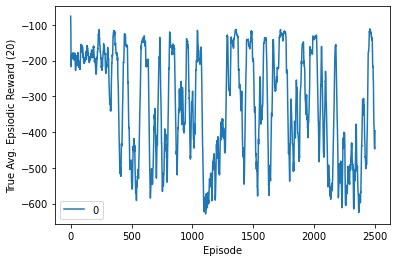

total time: 2434.8310124874115 s


In [32]:
run(total_trials=1, total_episodes=2500, buffer_capacity=500000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=30000, continuous=False, std_dev=0.7, std_dev_func=decreasing_std)

Ep 0 * AvgReward -172.20 * true AvgReward -172.20 * Reward -172.20 * True Reward -172.20 * time 2.38 * step 116
Ep 1 * AvgReward -157.96 * true AvgReward -157.96 * Reward -143.73 * True Reward -143.73 * time 0.89 * step 204
Ep 2 * AvgReward -197.82 * true AvgReward -197.82 * Reward -277.55 * True Reward -277.55 * time 1.62 * step 330
Ep 3 * AvgReward -172.20 * true AvgReward -172.20 * Reward -95.34 * True Reward -95.34 * time 1.18 * step 404
Ep 4 * AvgReward -217.26 * true AvgReward -217.26 * Reward -397.50 * True Reward -397.50 * time 0.95 * step 494
Ep 5 * AvgReward -240.65 * true AvgReward -240.65 * Reward -357.55 * True Reward -357.55 * time 1.57 * step 610
Ep 6 * AvgReward -212.06 * true AvgReward -212.06 * Reward -40.56 * True Reward -40.56 * time 1.12 * step 695
Ep 7 * AvgReward -254.31 * true AvgReward -254.31 * Reward -550.09 * True Reward -550.09 * time 1.12 * step 781
Ep 8 * AvgReward -252.93 * true AvgReward -252.93 * Reward -241.82 * True Reward -241.82 * time 1.08 * step 

Ep 73 * AvgReward -114.77 * true AvgReward -114.77 * Reward -146.19 * True Reward -146.19 * time 0.97 * step 6690
Ep 74 * AvgReward -124.45 * true AvgReward -124.45 * Reward -177.10 * True Reward -177.10 * time 1.32 * step 6769
Ep 75 * AvgReward -126.82 * true AvgReward -126.82 * Reward -240.77 * True Reward -240.77 * time 1.46 * step 6891
Ep 76 * AvgReward -125.60 * true AvgReward -125.60 * Reward -106.69 * True Reward -106.69 * time 1.08 * step 6971
Ep 77 * AvgReward -128.42 * true AvgReward -128.42 * Reward -134.39 * True Reward -134.39 * time 1.51 * step 7066
Ep 78 * AvgReward -130.86 * true AvgReward -130.86 * Reward -127.97 * True Reward -127.97 * time 0.91 * step 7156
Ep 79 * AvgReward -133.10 * true AvgReward -133.10 * Reward -115.74 * True Reward -115.74 * time 1.66 * step 7247
Ep 80 * AvgReward -145.45 * true AvgReward -145.45 * Reward -343.44 * True Reward -343.44 * time 1.66 * step 7346
Ep 81 * AvgReward -133.21 * true AvgReward -133.21 * Reward -90.23 * True Reward -90.23 

Ep 145 * AvgReward -188.67 * true AvgReward -188.67 * Reward -177.13 * True Reward -177.13 * time 0.92 * step 13253
Ep 146 * AvgReward -185.09 * true AvgReward -185.09 * Reward -164.56 * True Reward -164.56 * time 1.74 * step 13351
Ep 147 * AvgReward -185.62 * true AvgReward -185.62 * Reward -112.98 * True Reward -112.98 * time 1.08 * step 13424
Ep 148 * AvgReward -187.05 * true AvgReward -187.05 * Reward -113.39 * True Reward -113.39 * time 1.26 * step 13504
Ep 149 * AvgReward -176.03 * true AvgReward -176.03 * Reward 12.30 * True Reward 12.30 * time 0.91 * step 13573
Ep 150 * AvgReward -173.78 * true AvgReward -173.78 * Reward -111.04 * True Reward -111.04 * time 1.05 * step 13651
Ep 151 * AvgReward -181.59 * true AvgReward -181.59 * Reward -216.79 * True Reward -216.79 * time 1.26 * step 13737
Ep 152 * AvgReward -182.60 * true AvgReward -182.60 * Reward -135.14 * True Reward -135.14 * time 1.60 * step 13827
Ep 153 * AvgReward -187.98 * true AvgReward -187.98 * Reward -163.36 * True 

Ep 217 * AvgReward -196.86 * true AvgReward -196.86 * Reward -141.08 * True Reward -141.08 * time 0.98 * step 19670
Ep 218 * AvgReward -203.69 * true AvgReward -203.69 * Reward -231.11 * True Reward -231.11 * time 0.94 * step 19777
Ep 219 * AvgReward -208.29 * true AvgReward -208.29 * Reward -183.61 * True Reward -183.61 * time 2.42 * step 19921
Ep 220 * AvgReward -213.46 * true AvgReward -213.46 * Reward -149.50 * True Reward -149.50 * time 1.02 * step 20023
Ep 221 * AvgReward -217.81 * true AvgReward -217.81 * Reward -396.37 * True Reward -396.37 * time 0.80 * step 20110
Ep 222 * AvgReward -212.88 * true AvgReward -212.88 * Reward -90.49 * True Reward -90.49 * time 0.95 * step 20186
Ep 223 * AvgReward -200.94 * true AvgReward -200.94 * Reward -272.43 * True Reward -272.43 * time 0.89 * step 20268
Ep 224 * AvgReward -186.75 * true AvgReward -186.75 * Reward -93.65 * True Reward -93.65 * time 0.78 * step 20346
Ep 225 * AvgReward -193.26 * true AvgReward -193.26 * Reward -374.15 * True 

Ep 288 * AvgReward -174.22 * true AvgReward -174.22 * Reward -104.91 * True Reward -104.91 * time 0.94 * step 26357
Ep 289 * AvgReward -169.17 * true AvgReward -169.17 * Reward -98.27 * True Reward -98.27 * time 0.65 * step 26423
Ep 290 * AvgReward -162.35 * true AvgReward -162.35 * Reward -72.45 * True Reward -72.45 * time 1.17 * step 26535
Ep 291 * AvgReward -148.87 * true AvgReward -148.87 * Reward -81.27 * True Reward -81.27 * time 0.85 * step 26600
Ep 292 * AvgReward -151.99 * true AvgReward -151.99 * Reward -184.14 * True Reward -184.14 * time 1.09 * step 26698
Ep 293 * AvgReward -162.90 * true AvgReward -162.90 * Reward -347.12 * True Reward -347.12 * time 0.90 * step 26796
Ep 294 * AvgReward -170.50 * true AvgReward -170.50 * Reward -239.56 * True Reward -239.56 * time 0.90 * step 26894
Ep 295 * AvgReward -169.49 * true AvgReward -169.49 * Reward -306.30 * True Reward -306.30 * time 0.71 * step 26970
Ep 296 * AvgReward -172.95 * true AvgReward -172.95 * Reward -50.40 * True Rew

Ep 359 * AvgReward -390.74 * true AvgReward -390.74 * Reward -123.52 * True Reward -123.52 * time 0.97 * step 31724
Ep 360 * AvgReward -375.59 * true AvgReward -375.59 * Reward -127.77 * True Reward -127.77 * time 0.97 * step 31804
Ep 361 * AvgReward -359.89 * true AvgReward -359.89 * Reward -193.59 * True Reward -193.59 * time 1.08 * step 31881
Ep 362 * AvgReward -339.99 * true AvgReward -339.99 * Reward -141.65 * True Reward -141.65 * time 1.49 * step 31961
Ep 363 * AvgReward -329.45 * true AvgReward -329.45 * Reward -126.71 * True Reward -126.71 * time 1.15 * step 32025
Ep 364 * AvgReward -308.13 * true AvgReward -308.13 * Reward -100.72 * True Reward -100.72 * time 0.84 * step 32082
Ep 365 * AvgReward -296.10 * true AvgReward -296.10 * Reward -189.51 * True Reward -189.51 * time 0.86 * step 32134
Ep 366 * AvgReward -282.60 * true AvgReward -282.60 * Reward -268.37 * True Reward -268.37 * time 1.06 * step 32199
Ep 367 * AvgReward -265.92 * true AvgReward -265.92 * Reward -120.32 * T

Ep 430 * AvgReward -117.60 * true AvgReward -117.60 * Reward -99.16 * True Reward -99.16 * time 1.44 * step 36778
Ep 431 * AvgReward -120.19 * true AvgReward -120.19 * Reward -183.75 * True Reward -183.75 * time 0.97 * step 36849
Ep 432 * AvgReward -144.55 * true AvgReward -144.55 * Reward -614.70 * True Reward -614.70 * time 1.32 * step 36945
Ep 433 * AvgReward -157.05 * true AvgReward -157.05 * Reward -349.13 * True Reward -349.13 * time 0.90 * step 37010
Ep 434 * AvgReward -159.84 * true AvgReward -159.84 * Reward -198.60 * True Reward -198.60 * time 0.76 * step 37071
Ep 435 * AvgReward -187.00 * true AvgReward -187.00 * Reward -563.57 * True Reward -563.57 * time 1.06 * step 37140
Ep 436 * AvgReward -204.60 * true AvgReward -204.60 * Reward -456.64 * True Reward -456.64 * time 1.14 * step 37212
Ep 437 * AvgReward -223.49 * true AvgReward -223.49 * Reward -553.00 * True Reward -553.00 * time 0.99 * step 37279
Ep 438 * AvgReward -246.15 * true AvgReward -246.15 * Reward -560.07 * Tru

Ep 501 * AvgReward -479.78 * true AvgReward -479.78 * Reward -571.60 * True Reward -571.60 * time 1.06 * step 41686
Ep 502 * AvgReward -499.16 * true AvgReward -499.16 * Reward -909.68 * True Reward -909.68 * time 1.13 * step 41768
Ep 503 * AvgReward -510.85 * true AvgReward -510.85 * Reward -731.37 * True Reward -731.37 * time 1.31 * step 41850
Ep 504 * AvgReward -515.44 * true AvgReward -515.44 * Reward -429.30 * True Reward -429.30 * time 0.85 * step 41910
Ep 505 * AvgReward -526.02 * true AvgReward -526.02 * Reward -354.10 * True Reward -354.10 * time 1.21 * step 41998
Ep 506 * AvgReward -547.43 * true AvgReward -547.43 * Reward -750.09 * True Reward -750.09 * time 1.03 * step 42074
Ep 507 * AvgReward -553.71 * true AvgReward -553.71 * Reward -449.65 * True Reward -449.65 * time 0.66 * step 42125
Ep 508 * AvgReward -579.61 * true AvgReward -579.61 * Reward -1000.94 * True Reward -1000.94 * time 1.57 * step 42212
Ep 509 * AvgReward -562.80 * true AvgReward -562.80 * Reward -442.43 *

Ep 572 * AvgReward -298.18 * true AvgReward -298.18 * Reward -554.95 * True Reward -554.95 * time 1.13 * step 46662
Ep 573 * AvgReward -270.55 * true AvgReward -270.55 * Reward -423.10 * True Reward -423.10 * time 1.08 * step 46729
Ep 574 * AvgReward -260.74 * true AvgReward -260.74 * Reward -523.74 * True Reward -523.74 * time 0.92 * step 46788
Ep 575 * AvgReward -266.42 * true AvgReward -266.42 * Reward -671.02 * True Reward -671.02 * time 1.26 * step 46865
Ep 576 * AvgReward -243.01 * true AvgReward -243.01 * Reward -360.99 * True Reward -360.99 * time 1.42 * step 46958
Ep 577 * AvgReward -265.94 * true AvgReward -265.94 * Reward -598.08 * True Reward -598.08 * time 1.09 * step 47024
Ep 578 * AvgReward -274.53 * true AvgReward -274.53 * Reward -308.94 * True Reward -308.94 * time 1.09 * step 47087
Ep 579 * AvgReward -285.35 * true AvgReward -285.35 * Reward -392.55 * True Reward -392.55 * time 0.98 * step 47148
Ep 580 * AvgReward -297.53 * true AvgReward -297.53 * Reward -447.95 * T

Ep 643 * AvgReward -236.62 * true AvgReward -236.62 * Reward -768.30 * True Reward -768.30 * time 1.00 * step 51347
Ep 644 * AvgReward -259.87 * true AvgReward -259.87 * Reward -573.84 * True Reward -573.84 * time 0.91 * step 51408
Ep 645 * AvgReward -294.97 * true AvgReward -294.97 * Reward -839.00 * True Reward -839.00 * time 1.34 * step 51487
Ep 646 * AvgReward -308.94 * true AvgReward -308.94 * Reward -399.55 * True Reward -399.55 * time 0.97 * step 51548
Ep 647 * AvgReward -308.50 * true AvgReward -308.50 * Reward -131.51 * True Reward -131.51 * time 1.16 * step 51614
Ep 648 * AvgReward -278.98 * true AvgReward -278.98 * Reward -16.11 * True Reward -16.11 * time 1.53 * step 51697
Ep 649 * AvgReward -264.83 * true AvgReward -264.83 * Reward -131.78 * True Reward -131.78 * time 1.19 * step 51770
Ep 650 * AvgReward -239.48 * true AvgReward -239.48 * Reward 4.19 * True Reward 4.19 * time 1.42 * step 51864
Ep 651 * AvgReward -225.34 * true AvgReward -225.34 * Reward -103.47 * True Rewa

Ep 714 * AvgReward -266.72 * true AvgReward -266.72 * Reward -121.15 * True Reward -121.15 * time 1.39 * step 56194
Ep 715 * AvgReward -257.19 * true AvgReward -257.19 * Reward -317.26 * True Reward -317.26 * time 0.94 * step 56252
Ep 716 * AvgReward -237.95 * true AvgReward -237.95 * Reward -115.83 * True Reward -115.83 * time 0.94 * step 56308
Ep 717 * AvgReward -230.40 * true AvgReward -230.40 * Reward -188.90 * True Reward -188.90 * time 0.94 * step 56378
Ep 718 * AvgReward -226.75 * true AvgReward -226.75 * Reward -146.78 * True Reward -146.78 * time 0.96 * step 56442
Ep 719 * AvgReward -224.67 * true AvgReward -224.67 * Reward -110.72 * True Reward -110.72 * time 1.16 * step 56521
Ep 720 * AvgReward -226.79 * true AvgReward -226.79 * Reward -158.85 * True Reward -158.85 * time 1.29 * step 56595
Ep 721 * AvgReward -195.36 * true AvgReward -195.36 * Reward -135.82 * True Reward -135.82 * time 0.92 * step 56659
Ep 722 * AvgReward -177.99 * true AvgReward -177.99 * Reward -128.14 * T

Ep 785 * AvgReward -270.61 * true AvgReward -270.61 * Reward -437.98 * True Reward -437.98 * time 1.02 * step 61113
Ep 786 * AvgReward -262.44 * true AvgReward -262.44 * Reward -212.48 * True Reward -212.48 * time 1.28 * step 61198
Ep 787 * AvgReward -241.03 * true AvgReward -241.03 * Reward -110.45 * True Reward -110.45 * time 1.01 * step 61276
Ep 788 * AvgReward -229.31 * true AvgReward -229.31 * Reward -139.76 * True Reward -139.76 * time 1.05 * step 61354
Ep 789 * AvgReward -230.53 * true AvgReward -230.53 * Reward -141.35 * True Reward -141.35 * time 0.92 * step 61426
Ep 790 * AvgReward -229.99 * true AvgReward -229.99 * Reward -131.66 * True Reward -131.66 * time 1.34 * step 61510
Ep 791 * AvgReward -222.51 * true AvgReward -222.51 * Reward 12.76 * True Reward 12.76 * time 1.43 * step 61613
Ep 792 * AvgReward -235.19 * true AvgReward -235.19 * Reward -385.97 * True Reward -385.97 * time 0.81 * step 61668
Ep 793 * AvgReward -252.50 * true AvgReward -252.50 * Reward -496.00 * True 

Ep 856 * AvgReward -280.97 * true AvgReward -280.97 * Reward -321.06 * True Reward -321.06 * time 1.17 * step 65863
Ep 857 * AvgReward -266.65 * true AvgReward -266.65 * Reward -136.37 * True Reward -136.37 * time 0.98 * step 65920
Ep 858 * AvgReward -266.14 * true AvgReward -266.14 * Reward -144.74 * True Reward -144.74 * time 0.86 * step 65981
Ep 859 * AvgReward -268.44 * true AvgReward -268.44 * Reward -141.76 * True Reward -141.76 * time 1.25 * step 66060
Ep 860 * AvgReward -271.31 * true AvgReward -271.31 * Reward -149.09 * True Reward -149.09 * time 1.05 * step 66120
Ep 861 * AvgReward -268.92 * true AvgReward -268.92 * Reward -163.71 * True Reward -163.71 * time 1.24 * step 66192
Ep 862 * AvgReward -239.97 * true AvgReward -239.97 * Reward -142.32 * True Reward -142.32 * time 1.30 * step 66263
Ep 863 * AvgReward -212.97 * true AvgReward -212.97 * Reward 19.63 * True Reward 19.63 * time 1.39 * step 66348
Ep 864 * AvgReward -183.28 * true AvgReward -183.28 * Reward -134.98 * True 

Ep 927 * AvgReward -171.09 * true AvgReward -171.09 * Reward -823.69 * True Reward -823.69 * time 1.25 * step 70901
Ep 928 * AvgReward -199.52 * true AvgReward -199.52 * Reward -691.38 * True Reward -691.38 * time 1.32 * step 70982
Ep 929 * AvgReward -222.42 * true AvgReward -222.42 * Reward -589.58 * True Reward -589.58 * time 1.46 * step 71073
Ep 930 * AvgReward -247.52 * true AvgReward -247.52 * Reward -632.32 * True Reward -632.32 * time 0.97 * step 71140
Ep 931 * AvgReward -266.30 * true AvgReward -266.30 * Reward -539.10 * True Reward -539.10 * time 0.86 * step 71209
Ep 932 * AvgReward -278.15 * true AvgReward -278.15 * Reward -324.47 * True Reward -324.47 * time 0.74 * step 71261
Ep 933 * AvgReward -291.64 * true AvgReward -291.64 * Reward -399.86 * True Reward -399.86 * time 0.92 * step 71312
Ep 934 * AvgReward -290.41 * true AvgReward -290.41 * Reward -108.65 * True Reward -108.65 * time 1.10 * step 71392
Ep 935 * AvgReward -286.82 * true AvgReward -286.82 * Reward -131.53 * T

Ep 998 * AvgReward -469.09 * true AvgReward -469.09 * Reward -713.29 * True Reward -713.29 * time 1.36 * step 75684
Ep 999 * AvgReward -467.15 * true AvgReward -467.15 * Reward -204.06 * True Reward -204.06 * time 0.78 * step 75742
Ep 1000 * AvgReward -452.27 * true AvgReward -452.27 * Reward -187.02 * True Reward -187.02 * time 1.19 * step 75819
Ep 1001 * AvgReward -453.19 * true AvgReward -453.19 * Reward -154.62 * True Reward -154.62 * time 0.67 * step 75878
Ep 1002 * AvgReward -439.68 * true AvgReward -439.68 * Reward -108.10 * True Reward -108.10 * time 1.31 * step 75957
Ep 1003 * AvgReward -420.96 * true AvgReward -420.96 * Reward -125.97 * True Reward -125.97 * time 1.08 * step 76033
Ep 1004 * AvgReward -384.92 * true AvgReward -384.92 * Reward -121.50 * True Reward -121.50 * time 0.89 * step 76090
Ep 1005 * AvgReward -369.06 * true AvgReward -369.06 * Reward -441.62 * True Reward -441.62 * time 1.00 * step 76163
Ep 1006 * AvgReward -368.17 * true AvgReward -368.17 * Reward -206

Ep 1069 * AvgReward -349.44 * true AvgReward -349.44 * Reward -105.67 * True Reward -105.67 * time 1.01 * step 80672
Ep 1070 * AvgReward -329.79 * true AvgReward -329.79 * Reward -134.77 * True Reward -134.77 * time 0.86 * step 80723
Ep 1071 * AvgReward -295.53 * true AvgReward -295.53 * Reward -97.87 * True Reward -97.87 * time 0.89 * step 80780
Ep 1072 * AvgReward -278.94 * true AvgReward -278.94 * Reward -53.03 * True Reward -53.03 * time 0.98 * step 80836
Ep 1073 * AvgReward -260.37 * true AvgReward -260.37 * Reward -162.25 * True Reward -162.25 * time 1.37 * step 80911
Ep 1074 * AvgReward -226.87 * true AvgReward -226.87 * Reward -133.39 * True Reward -133.39 * time 1.22 * step 80992
Ep 1075 * AvgReward -200.60 * true AvgReward -200.60 * Reward -146.63 * True Reward -146.63 * time 0.99 * step 81057
Ep 1076 * AvgReward -192.95 * true AvgReward -192.95 * Reward -111.57 * True Reward -111.57 * time 0.65 * step 81109
Ep 1077 * AvgReward -179.23 * true AvgReward -179.23 * Reward -137.6

Ep 1140 * AvgReward -139.85 * true AvgReward -139.85 * Reward -199.38 * True Reward -199.38 * time 1.27 * step 85489
Ep 1141 * AvgReward -141.65 * true AvgReward -141.65 * Reward -150.62 * True Reward -150.62 * time 1.13 * step 85563
Ep 1142 * AvgReward -141.68 * true AvgReward -141.68 * Reward -126.48 * True Reward -126.48 * time 1.12 * step 85625
Ep 1143 * AvgReward -137.70 * true AvgReward -137.70 * Reward -39.45 * True Reward -39.45 * time 1.37 * step 85717
Ep 1144 * AvgReward -136.81 * true AvgReward -136.81 * Reward -152.57 * True Reward -152.57 * time 1.32 * step 85795
Ep 1145 * AvgReward -125.05 * true AvgReward -125.05 * Reward 24.23 * True Reward 24.23 * time 0.91 * step 85861
Ep 1146 * AvgReward -128.51 * true AvgReward -128.51 * Reward -237.91 * True Reward -237.91 * time 1.06 * step 85933
Ep 1147 * AvgReward -132.01 * true AvgReward -132.01 * Reward -90.54 * True Reward -90.54 * time 0.67 * step 85986
Ep 1148 * AvgReward -130.01 * true AvgReward -130.01 * Reward -99.15 * T

Ep 1211 * AvgReward -569.33 * true AvgReward -569.33 * Reward -781.32 * True Reward -781.32 * time 1.52 * step 90428
Ep 1212 * AvgReward -569.33 * true AvgReward -569.33 * Reward -568.37 * True Reward -568.37 * time 1.16 * step 90489
Ep 1213 * AvgReward -576.39 * true AvgReward -576.39 * Reward -547.52 * True Reward -547.52 * time 1.15 * step 90557
Ep 1214 * AvgReward -548.67 * true AvgReward -548.67 * Reward -149.96 * True Reward -149.96 * time 0.87 * step 90610
Ep 1215 * AvgReward -517.91 * true AvgReward -517.91 * Reward -123.25 * True Reward -123.25 * time 0.88 * step 90668
Ep 1216 * AvgReward -494.69 * true AvgReward -494.69 * Reward -157.61 * True Reward -157.61 * time 0.98 * step 90734
Ep 1217 * AvgReward -472.14 * true AvgReward -472.14 * Reward -267.84 * True Reward -267.84 * time 1.16 * step 90801
Ep 1218 * AvgReward -478.69 * true AvgReward -478.69 * Reward -482.48 * True Reward -482.48 * time 1.29 * step 90872
Ep 1219 * AvgReward -492.57 * true AvgReward -492.57 * Reward -7

Ep 1282 * AvgReward -392.71 * true AvgReward -392.71 * Reward -203.12 * True Reward -203.12 * time 0.91 * step 95231
Ep 1283 * AvgReward -392.74 * true AvgReward -392.74 * Reward -180.65 * True Reward -180.65 * time 1.17 * step 95307
Ep 1284 * AvgReward -391.31 * true AvgReward -391.31 * Reward -138.03 * True Reward -138.03 * time 0.81 * step 95362
Ep 1285 * AvgReward -389.50 * true AvgReward -389.50 * Reward -118.33 * True Reward -118.33 * time 1.34 * step 95440
Ep 1286 * AvgReward -366.33 * true AvgReward -366.33 * Reward -162.02 * True Reward -162.02 * time 0.95 * step 95509
Ep 1287 * AvgReward -367.91 * true AvgReward -367.91 * Reward -123.76 * True Reward -123.76 * time 1.13 * step 95589
Ep 1288 * AvgReward -353.65 * true AvgReward -353.65 * Reward -178.75 * True Reward -178.75 * time 1.27 * step 95666
Ep 1289 * AvgReward -309.80 * true AvgReward -309.80 * Reward -132.02 * True Reward -132.02 * time 1.06 * step 95735
Ep 1290 * AvgReward -286.18 * true AvgReward -286.18 * Reward -1

Ep 1353 * AvgReward -532.85 * true AvgReward -532.85 * Reward -348.24 * True Reward -348.24 * time 0.84 * step 100099
Ep 1354 * AvgReward -513.16 * true AvgReward -513.16 * Reward -133.00 * True Reward -133.00 * time 0.85 * step 100159
Ep 1355 * AvgReward -483.62 * true AvgReward -483.62 * Reward -126.05 * True Reward -126.05 * time 0.99 * step 100231
Ep 1356 * AvgReward -467.40 * true AvgReward -467.40 * Reward -112.68 * True Reward -112.68 * time 1.37 * step 100322
Ep 1357 * AvgReward -449.09 * true AvgReward -449.09 * Reward -146.73 * True Reward -146.73 * time 0.90 * step 100380
Ep 1358 * AvgReward -436.34 * true AvgReward -436.34 * Reward -153.99 * True Reward -153.99 * time 1.29 * step 100464
Ep 1359 * AvgReward -437.18 * true AvgReward -437.18 * Reward -473.32 * True Reward -473.32 * time 1.24 * step 100547
Ep 1360 * AvgReward -424.95 * true AvgReward -424.95 * Reward -530.56 * True Reward -530.56 * time 1.03 * step 100627
Ep 1361 * AvgReward -407.10 * true AvgReward -407.10 * R

Ep 1423 * AvgReward -508.89 * true AvgReward -508.89 * Reward -147.09 * True Reward -147.09 * time 1.11 * step 104909
Ep 1424 * AvgReward -487.17 * true AvgReward -487.17 * Reward -97.27 * True Reward -97.27 * time 0.90 * step 104961
Ep 1425 * AvgReward -475.84 * true AvgReward -475.84 * Reward -153.39 * True Reward -153.39 * time 1.26 * step 105036
Ep 1426 * AvgReward -460.03 * true AvgReward -460.03 * Reward -101.26 * True Reward -101.26 * time 1.02 * step 105090
Ep 1427 * AvgReward -436.65 * true AvgReward -436.65 * Reward -113.17 * True Reward -113.17 * time 1.09 * step 105146
Ep 1428 * AvgReward -400.20 * true AvgReward -400.20 * Reward -113.01 * True Reward -113.01 * time 1.19 * step 105218
Ep 1429 * AvgReward -371.05 * true AvgReward -371.05 * Reward -174.29 * True Reward -174.29 * time 1.25 * step 105290
Ep 1430 * AvgReward -364.81 * true AvgReward -364.81 * Reward -408.85 * True Reward -408.85 * time 0.91 * step 105347
Ep 1431 * AvgReward -348.44 * true AvgReward -348.44 * Rew

Ep 1493 * AvgReward -255.92 * true AvgReward -255.92 * Reward -108.66 * True Reward -108.66 * time 1.26 * step 109693
Ep 1494 * AvgReward -253.31 * true AvgReward -253.31 * Reward -123.80 * True Reward -123.80 * time 0.90 * step 109757
Ep 1495 * AvgReward -251.25 * true AvgReward -251.25 * Reward -131.87 * True Reward -131.87 * time 0.76 * step 109818
Ep 1496 * AvgReward -254.80 * true AvgReward -254.80 * Reward -176.02 * True Reward -176.02 * time 0.94 * step 109893
Ep 1497 * AvgReward -256.41 * true AvgReward -256.41 * Reward -129.97 * True Reward -129.97 * time 0.93 * step 109965
Ep 1498 * AvgReward -254.74 * true AvgReward -254.74 * Reward -138.15 * True Reward -138.15 * time 0.78 * step 110017
Ep 1499 * AvgReward -252.60 * true AvgReward -252.60 * Reward -84.35 * True Reward -84.35 * time 0.60 * step 110070
Ep 1500 * AvgReward -253.56 * true AvgReward -253.56 * Reward -179.34 * True Reward -179.34 * time 1.36 * step 110155
Ep 1501 * AvgReward -263.48 * true AvgReward -263.48 * Rew

Ep 1563 * AvgReward -622.67 * true AvgReward -622.67 * Reward -722.74 * True Reward -722.74 * time 0.99 * step 114361
Ep 1564 * AvgReward -629.43 * true AvgReward -629.43 * Reward -436.38 * True Reward -436.38 * time 0.81 * step 114417
Ep 1565 * AvgReward -641.09 * true AvgReward -641.09 * Reward -782.65 * True Reward -782.65 * time 1.06 * step 114494
Ep 1566 * AvgReward -634.71 * true AvgReward -634.71 * Reward -455.07 * True Reward -455.07 * time 0.95 * step 114548
Ep 1567 * AvgReward -618.16 * true AvgReward -618.16 * Reward -579.80 * True Reward -579.80 * time 0.96 * step 114609
Ep 1568 * AvgReward -629.98 * true AvgReward -629.98 * Reward -684.37 * True Reward -684.37 * time 1.22 * step 114688
Ep 1569 * AvgReward -620.37 * true AvgReward -620.37 * Reward -562.87 * True Reward -562.87 * time 1.02 * step 114751
Ep 1570 * AvgReward -618.21 * true AvgReward -618.21 * Reward -535.59 * True Reward -535.59 * time 0.93 * step 114818
Ep 1571 * AvgReward -613.38 * true AvgReward -613.38 * R

Ep 1633 * AvgReward -457.32 * true AvgReward -457.32 * Reward -290.73 * True Reward -290.73 * time 0.88 * step 119218
Ep 1634 * AvgReward -441.35 * true AvgReward -441.35 * Reward -434.48 * True Reward -434.48 * time 1.24 * step 119297
Ep 1635 * AvgReward -413.71 * true AvgReward -413.71 * Reward -390.09 * True Reward -390.09 * time 0.81 * step 119349
Ep 1636 * AvgReward -391.44 * true AvgReward -391.44 * Reward -142.05 * True Reward -142.05 * time 1.29 * step 119417
Ep 1637 * AvgReward -373.52 * true AvgReward -373.52 * Reward -121.32 * True Reward -121.32 * time 0.74 * step 119469
Ep 1638 * AvgReward -334.74 * true AvgReward -334.74 * Reward -143.00 * True Reward -143.00 * time 1.00 * step 119522
Ep 1639 * AvgReward -337.50 * true AvgReward -337.50 * Reward -464.05 * True Reward -464.05 * time 0.90 * step 119586
Ep 1640 * AvgReward -329.32 * true AvgReward -329.32 * Reward -388.63 * True Reward -388.63 * time 0.81 * step 119641
Ep 1641 * AvgReward -346.36 * true AvgReward -346.36 * R

Ep 1703 * AvgReward -225.52 * true AvgReward -225.52 * Reward -172.47 * True Reward -172.47 * time 1.05 * step 124071
Ep 1704 * AvgReward -197.40 * true AvgReward -197.40 * Reward -128.31 * True Reward -128.31 * time 0.89 * step 124137
Ep 1705 * AvgReward -199.58 * true AvgReward -199.58 * Reward -132.95 * True Reward -132.95 * time 0.93 * step 124196
Ep 1706 * AvgReward -202.39 * true AvgReward -202.39 * Reward -264.37 * True Reward -264.37 * time 1.25 * step 124264
Ep 1707 * AvgReward -232.26 * true AvgReward -232.26 * Reward -762.94 * True Reward -762.94 * time 1.06 * step 124340
Ep 1708 * AvgReward -250.00 * true AvgReward -250.00 * Reward -511.41 * True Reward -511.41 * time 0.98 * step 124406
Ep 1709 * AvgReward -264.20 * true AvgReward -264.20 * Reward -407.03 * True Reward -407.03 * time 1.42 * step 124509
Ep 1710 * AvgReward -281.61 * true AvgReward -281.61 * Reward -482.07 * True Reward -482.07 * time 1.29 * step 124580
Ep 1711 * AvgReward -316.33 * true AvgReward -316.33 * R

Ep 1773 * AvgReward -312.82 * true AvgReward -312.82 * Reward -114.96 * True Reward -114.96 * time 1.16 * step 128844
Ep 1774 * AvgReward -314.15 * true AvgReward -314.15 * Reward -154.90 * True Reward -154.90 * time 1.03 * step 128912
Ep 1775 * AvgReward -314.37 * true AvgReward -314.37 * Reward -144.05 * True Reward -144.05 * time 0.79 * step 128966
Ep 1776 * AvgReward -340.39 * true AvgReward -340.39 * Reward -699.60 * True Reward -699.60 * time 1.74 * step 129073
Ep 1777 * AvgReward -370.41 * true AvgReward -370.41 * Reward -726.31 * True Reward -726.31 * time 1.08 * step 129147
Ep 1778 * AvgReward -385.83 * true AvgReward -385.83 * Reward -454.36 * True Reward -454.36 * time 0.68 * step 129201
Ep 1779 * AvgReward -415.86 * true AvgReward -415.86 * Reward -620.73 * True Reward -620.73 * time 1.11 * step 129268
Ep 1780 * AvgReward -439.07 * true AvgReward -439.07 * Reward -622.48 * True Reward -622.48 * time 1.27 * step 129342
Ep 1781 * AvgReward -452.05 * true AvgReward -452.05 * R

Ep 1843 * AvgReward -261.87 * true AvgReward -261.87 * Reward -291.02 * True Reward -291.02 * time 1.57 * step 133758
Ep 1844 * AvgReward -268.95 * true AvgReward -268.95 * Reward -281.37 * True Reward -281.37 * time 1.24 * step 133838
Ep 1845 * AvgReward -277.43 * true AvgReward -277.43 * Reward -423.08 * True Reward -423.08 * time 0.65 * step 133894
Ep 1846 * AvgReward -291.79 * true AvgReward -291.79 * Reward -779.67 * True Reward -779.67 * time 1.21 * step 133972
Ep 1847 * AvgReward -281.73 * true AvgReward -281.73 * Reward -143.90 * True Reward -143.90 * time 1.00 * step 134047
Ep 1848 * AvgReward -260.21 * true AvgReward -260.21 * Reward -299.74 * True Reward -299.74 * time 1.01 * step 134111
Ep 1849 * AvgReward -250.00 * true AvgReward -250.00 * Reward -498.85 * True Reward -498.85 * time 0.94 * step 134169
Ep 1850 * AvgReward -271.09 * true AvgReward -271.09 * Reward -857.77 * True Reward -857.77 * time 1.35 * step 134251
Ep 1851 * AvgReward -289.19 * true AvgReward -289.19 * R

Ep 1913 * AvgReward -457.47 * true AvgReward -457.47 * Reward -523.28 * True Reward -523.28 * time 0.89 * step 138630
Ep 1914 * AvgReward -458.75 * true AvgReward -458.75 * Reward -125.97 * True Reward -125.97 * time 0.70 * step 138685
Ep 1915 * AvgReward -443.65 * true AvgReward -443.65 * Reward -131.64 * True Reward -131.64 * time 0.73 * step 138744
Ep 1916 * AvgReward -421.58 * true AvgReward -421.58 * Reward -126.85 * True Reward -126.85 * time 0.65 * step 138797
Ep 1917 * AvgReward -399.68 * true AvgReward -399.68 * Reward -119.71 * True Reward -119.71 * time 1.07 * step 138858
Ep 1918 * AvgReward -384.79 * true AvgReward -384.79 * Reward -108.26 * True Reward -108.26 * time 1.15 * step 138942
Ep 1919 * AvgReward -372.67 * true AvgReward -372.67 * Reward -303.25 * True Reward -303.25 * time 0.80 * step 139002
Ep 1920 * AvgReward -353.38 * true AvgReward -353.38 * Reward -393.29 * True Reward -393.29 * time 1.25 * step 139093
Ep 1921 * AvgReward -338.81 * true AvgReward -338.81 * R

Ep 1983 * AvgReward -234.52 * true AvgReward -234.52 * Reward -309.50 * True Reward -309.50 * time 0.89 * step 143084
Ep 1984 * AvgReward -257.81 * true AvgReward -257.81 * Reward -607.79 * True Reward -607.79 * time 1.16 * step 143158
Ep 1985 * AvgReward -258.59 * true AvgReward -258.59 * Reward -152.12 * True Reward -152.12 * time 1.20 * step 143230
Ep 1986 * AvgReward -259.59 * true AvgReward -259.59 * Reward -118.90 * True Reward -118.90 * time 1.49 * step 143315
Ep 1987 * AvgReward -259.32 * true AvgReward -259.32 * Reward -142.05 * True Reward -142.05 * time 0.93 * step 143372
Ep 1988 * AvgReward -258.93 * true AvgReward -258.93 * Reward -128.10 * True Reward -128.10 * time 1.26 * step 143441
Ep 1989 * AvgReward -256.67 * true AvgReward -256.67 * Reward -100.55 * True Reward -100.55 * time 1.07 * step 143502
Ep 1990 * AvgReward -256.85 * true AvgReward -256.85 * Reward -146.00 * True Reward -146.00 * time 1.43 * step 143592
Ep 1991 * AvgReward -257.37 * true AvgReward -257.37 * R

Ep 2053 * AvgReward -516.77 * true AvgReward -516.77 * Reward -661.64 * True Reward -661.64 * time 1.36 * step 147785
Ep 2054 * AvgReward -514.91 * true AvgReward -514.91 * Reward -377.08 * True Reward -377.08 * time 0.73 * step 147836
Ep 2055 * AvgReward -504.37 * true AvgReward -504.37 * Reward -575.68 * True Reward -575.68 * time 1.13 * step 147908
Ep 2056 * AvgReward -497.36 * true AvgReward -497.36 * Reward -468.84 * True Reward -468.84 * time 1.00 * step 147979
Ep 2057 * AvgReward -485.64 * true AvgReward -485.64 * Reward -148.63 * True Reward -148.63 * time 1.31 * step 148057
Ep 2058 * AvgReward -466.02 * true AvgReward -466.02 * Reward -117.77 * True Reward -117.77 * time 1.38 * step 148142
Ep 2059 * AvgReward -460.18 * true AvgReward -460.18 * Reward -398.73 * True Reward -398.73 * time 0.76 * step 148197
Ep 2060 * AvgReward -455.06 * true AvgReward -455.06 * Reward -339.96 * True Reward -339.96 * time 0.76 * step 148252
Ep 2061 * AvgReward -456.89 * true AvgReward -456.89 * R

Ep 2123 * AvgReward -310.75 * true AvgReward -310.75 * Reward -128.23 * True Reward -128.23 * time 0.91 * step 152610
Ep 2124 * AvgReward -303.30 * true AvgReward -303.30 * Reward -153.98 * True Reward -153.98 * time 1.13 * step 152677
Ep 2125 * AvgReward -276.86 * true AvgReward -276.86 * Reward -123.93 * True Reward -123.93 * time 0.99 * step 152738
Ep 2126 * AvgReward -241.89 * true AvgReward -241.89 * Reward -157.06 * True Reward -157.06 * time 1.08 * step 152811
Ep 2127 * AvgReward -262.88 * true AvgReward -262.88 * Reward -773.03 * True Reward -773.03 * time 1.36 * step 152895
Ep 2128 * AvgReward -271.86 * true AvgReward -271.86 * Reward -646.48 * True Reward -646.48 * time 1.89 * step 153004
Ep 2129 * AvgReward -273.23 * true AvgReward -273.23 * Reward -412.34 * True Reward -412.34 * time 1.01 * step 153058
Ep 2130 * AvgReward -274.98 * true AvgReward -274.98 * Reward -757.46 * True Reward -757.46 * time 1.31 * step 153132
Ep 2131 * AvgReward -282.31 * true AvgReward -282.31 * R

Ep 2193 * AvgReward -222.16 * true AvgReward -222.16 * Reward -563.02 * True Reward -563.02 * time 1.16 * step 157514
Ep 2194 * AvgReward -220.05 * true AvgReward -220.05 * Reward -89.17 * True Reward -89.17 * time 0.88 * step 157566
Ep 2195 * AvgReward -221.55 * true AvgReward -221.55 * Reward -160.24 * True Reward -160.24 * time 0.79 * step 157622
Ep 2196 * AvgReward -219.86 * true AvgReward -219.86 * Reward -168.63 * True Reward -168.63 * time 1.16 * step 157692
Ep 2197 * AvgReward -234.70 * true AvgReward -234.70 * Reward -461.76 * True Reward -461.76 * time 1.12 * step 157764
Ep 2198 * AvgReward -252.22 * true AvgReward -252.22 * Reward -480.42 * True Reward -480.42 * time 0.80 * step 157818
Ep 2199 * AvgReward -273.04 * true AvgReward -273.04 * Reward -559.75 * True Reward -559.75 * time 1.19 * step 157887
Ep 2200 * AvgReward -271.72 * true AvgReward -271.72 * Reward -95.09 * True Reward -95.09 * time 1.01 * step 157942
Ep 2201 * AvgReward -269.96 * true AvgReward -269.96 * Rewar

Ep 2263 * AvgReward -348.31 * true AvgReward -348.31 * Reward -90.45 * True Reward -90.45 * time 1.08 * step 162342
Ep 2264 * AvgReward -350.88 * true AvgReward -350.88 * Reward -157.18 * True Reward -157.18 * time 1.10 * step 162409
Ep 2265 * AvgReward -351.99 * true AvgReward -351.99 * Reward -144.36 * True Reward -144.36 * time 0.84 * step 162473
Ep 2266 * AvgReward -352.02 * true AvgReward -352.02 * Reward -159.73 * True Reward -159.73 * time 1.33 * step 162565
Ep 2267 * AvgReward -350.76 * true AvgReward -350.76 * Reward -109.75 * True Reward -109.75 * time 1.33 * step 162644
Ep 2268 * AvgReward -345.26 * true AvgReward -345.26 * Reward 20.92 * True Reward 20.92 * time 0.91 * step 162718
Ep 2269 * AvgReward -344.90 * true AvgReward -344.90 * Reward -159.69 * True Reward -159.69 * time 0.83 * step 162784
Ep 2270 * AvgReward -335.23 * true AvgReward -335.23 * Reward -158.59 * True Reward -158.59 * time 1.18 * step 162871
Ep 2271 * AvgReward -330.34 * true AvgReward -330.34 * Reward 

Ep 2333 * AvgReward -502.57 * true AvgReward -502.57 * Reward -767.20 * True Reward -767.20 * time 1.29 * step 167026
Ep 2334 * AvgReward -504.67 * true AvgReward -504.67 * Reward -461.61 * True Reward -461.61 * time 0.93 * step 167084
Ep 2335 * AvgReward -485.30 * true AvgReward -485.30 * Reward -422.02 * True Reward -422.02 * time 1.07 * step 167142
Ep 2336 * AvgReward -502.20 * true AvgReward -502.20 * Reward -796.34 * True Reward -796.34 * time 1.46 * step 167224
Ep 2337 * AvgReward -519.66 * true AvgReward -519.66 * Reward -774.61 * True Reward -774.61 * time 1.42 * step 167305
Ep 2338 * AvgReward -500.11 * true AvgReward -500.11 * Reward -397.49 * True Reward -397.49 * time 1.52 * step 167382
Ep 2339 * AvgReward -482.93 * true AvgReward -482.93 * Reward -584.79 * True Reward -584.79 * time 0.97 * step 167450
Ep 2340 * AvgReward -479.37 * true AvgReward -479.37 * Reward -492.77 * True Reward -492.77 * time 0.91 * step 167517
Ep 2341 * AvgReward -487.67 * true AvgReward -487.67 * R

Ep 2403 * AvgReward -211.57 * true AvgReward -211.57 * Reward -149.61 * True Reward -149.61 * time 1.04 * step 171745
Ep 2404 * AvgReward -213.44 * true AvgReward -213.44 * Reward -181.32 * True Reward -181.32 * time 0.91 * step 171814
Ep 2405 * AvgReward -216.48 * true AvgReward -216.48 * Reward -175.17 * True Reward -175.17 * time 1.06 * step 171881
Ep 2406 * AvgReward -216.39 * true AvgReward -216.39 * Reward -137.27 * True Reward -137.27 * time 1.24 * step 171956
Ep 2407 * AvgReward -216.65 * true AvgReward -216.65 * Reward -136.20 * True Reward -136.20 * time 0.90 * step 172012
Ep 2408 * AvgReward -205.97 * true AvgReward -205.97 * Reward -178.06 * True Reward -178.06 * time 1.09 * step 172089
Ep 2409 * AvgReward -187.30 * true AvgReward -187.30 * Reward -109.95 * True Reward -109.95 * time 0.89 * step 172152
Ep 2410 * AvgReward -177.98 * true AvgReward -177.98 * Reward -305.93 * True Reward -305.93 * time 0.72 * step 172210
Ep 2411 * AvgReward -171.95 * true AvgReward -171.95 * R

Ep 2473 * AvgReward -362.00 * true AvgReward -362.00 * Reward -97.14 * True Reward -97.14 * time 0.69 * step 176593
Ep 2474 * AvgReward -345.01 * true AvgReward -345.01 * Reward -142.58 * True Reward -142.58 * time 0.92 * step 176654
Ep 2475 * AvgReward -310.28 * true AvgReward -310.28 * Reward -152.80 * True Reward -152.80 * time 1.18 * step 176723
Ep 2476 * AvgReward -292.34 * true AvgReward -292.34 * Reward -147.32 * True Reward -147.32 * time 0.98 * step 176787
Ep 2477 * AvgReward -276.30 * true AvgReward -276.30 * Reward -123.13 * True Reward -123.13 * time 0.95 * step 176853
Ep 2478 * AvgReward -246.17 * true AvgReward -246.17 * Reward -113.85 * True Reward -113.85 * time 0.69 * step 176904
Ep 2479 * AvgReward -208.95 * true AvgReward -208.95 * Reward -154.74 * True Reward -154.74 * time 0.96 * step 176965
Ep 2480 * AvgReward -172.99 * true AvgReward -172.99 * Reward -112.30 * True Reward -112.30 * time 1.20 * step 177046
Ep 2481 * AvgReward -155.76 * true AvgReward -155.76 * Rew

Ep 45 * AvgReward -202.93 * true AvgReward -202.93 * Reward -513.49 * True Reward -513.49 * time 1.71 * step 4292
Ep 46 * AvgReward -193.86 * true AvgReward -193.86 * Reward -51.37 * True Reward -51.37 * time 1.48 * step 4397
Ep 47 * AvgReward -192.74 * true AvgReward -192.74 * Reward -258.58 * True Reward -258.58 * time 1.33 * step 4467
Ep 48 * AvgReward -185.48 * true AvgReward -185.48 * Reward -77.75 * True Reward -77.75 * time 1.20 * step 4529
Ep 49 * AvgReward -184.19 * true AvgReward -184.19 * Reward -72.93 * True Reward -72.93 * time 1.28 * step 4620
Ep 50 * AvgReward -193.69 * true AvgReward -193.69 * Reward -299.35 * True Reward -299.35 * time 2.40 * step 4742
Ep 51 * AvgReward -192.62 * true AvgReward -192.62 * Reward -116.42 * True Reward -116.42 * time 1.01 * step 4813
Ep 52 * AvgReward -185.89 * true AvgReward -185.89 * Reward -57.92 * True Reward -57.92 * time 1.29 * step 4888
Ep 53 * AvgReward -190.14 * true AvgReward -190.14 * Reward -302.38 * True Reward -302.38 * time

Ep 118 * AvgReward -173.84 * true AvgReward -173.84 * Reward -245.75 * True Reward -245.75 * time 1.50 * step 11004
Ep 119 * AvgReward -173.87 * true AvgReward -173.87 * Reward -130.79 * True Reward -130.79 * time 1.02 * step 11078
Ep 120 * AvgReward -162.46 * true AvgReward -162.46 * Reward -133.49 * True Reward -133.49 * time 1.75 * step 11184
Ep 121 * AvgReward -161.84 * true AvgReward -161.84 * Reward -147.08 * True Reward -147.08 * time 1.27 * step 11295
Ep 122 * AvgReward -152.40 * true AvgReward -152.40 * Reward -110.58 * True Reward -110.58 * time 1.85 * step 11400
Ep 123 * AvgReward -142.18 * true AvgReward -142.18 * Reward -174.88 * True Reward -174.88 * time 1.26 * step 11470
Ep 124 * AvgReward -149.45 * true AvgReward -149.45 * Reward -231.61 * True Reward -231.61 * time 1.39 * step 11565
Ep 125 * AvgReward -155.72 * true AvgReward -155.72 * Reward -159.61 * True Reward -159.61 * time 1.18 * step 11669
Ep 126 * AvgReward -163.76 * true AvgReward -163.76 * Reward -238.80 * T

Ep 189 * AvgReward -202.75 * true AvgReward -202.75 * Reward -84.59 * True Reward -84.59 * time 1.01 * step 17394
Ep 190 * AvgReward -202.31 * true AvgReward -202.31 * Reward -158.71 * True Reward -158.71 * time 1.17 * step 17468
Ep 191 * AvgReward -199.05 * true AvgReward -199.05 * Reward -210.59 * True Reward -210.59 * time 2.08 * step 17583
Ep 192 * AvgReward -192.61 * true AvgReward -192.61 * Reward -100.64 * True Reward -100.64 * time 1.31 * step 17653
Ep 193 * AvgReward -183.26 * true AvgReward -183.26 * Reward -78.47 * True Reward -78.47 * time 0.69 * step 17716
Ep 194 * AvgReward -175.87 * true AvgReward -175.87 * Reward -182.53 * True Reward -182.53 * time 1.48 * step 17814
Ep 195 * AvgReward -177.67 * true AvgReward -177.67 * Reward -270.71 * True Reward -270.71 * time 1.43 * step 17908
Ep 196 * AvgReward -177.11 * true AvgReward -177.11 * Reward -94.47 * True Reward -94.47 * time 0.86 * step 17971
Ep 197 * AvgReward -185.56 * true AvgReward -185.56 * Reward -413.91 * True Re

Ep 260 * AvgReward -155.85 * true AvgReward -155.85 * Reward -122.80 * True Reward -122.80 * time 1.43 * step 23919
Ep 261 * AvgReward -158.47 * true AvgReward -158.47 * Reward -371.15 * True Reward -371.15 * time 1.51 * step 24000
Ep 262 * AvgReward -149.88 * true AvgReward -149.88 * Reward -371.68 * True Reward -371.68 * time 2.23 * step 24107
Ep 263 * AvgReward -143.66 * true AvgReward -143.66 * Reward -88.79 * True Reward -88.79 * time 1.33 * step 24182
Ep 264 * AvgReward -141.96 * true AvgReward -141.96 * Reward -92.13 * True Reward -92.13 * time 1.33 * step 24264
Ep 265 * AvgReward -142.26 * true AvgReward -142.26 * Reward -133.95 * True Reward -133.95 * time 1.39 * step 24346
Ep 266 * AvgReward -146.35 * true AvgReward -146.35 * Reward -172.98 * True Reward -172.98 * time 1.57 * step 24450
Ep 267 * AvgReward -143.24 * true AvgReward -143.24 * Reward -128.95 * True Reward -128.95 * time 2.24 * step 24575
Ep 268 * AvgReward -151.01 * true AvgReward -151.01 * Reward -100.98 * True 

Ep 332 * AvgReward -293.12 * true AvgReward -293.12 * Reward -166.59 * True Reward -166.59 * time 1.45 * step 30469
Ep 333 * AvgReward -299.17 * true AvgReward -299.17 * Reward -219.40 * True Reward -219.40 * time 1.68 * step 30558
Ep 334 * AvgReward -302.33 * true AvgReward -302.33 * Reward -518.55 * True Reward -518.55 * time 1.12 * step 30619
Ep 335 * AvgReward -312.13 * true AvgReward -312.13 * Reward -404.92 * True Reward -404.92 * time 0.94 * step 30671
Ep 336 * AvgReward -342.37 * true AvgReward -342.37 * Reward -872.56 * True Reward -872.56 * time 1.44 * step 30757
Ep 337 * AvgReward -357.79 * true AvgReward -357.79 * Reward -488.80 * True Reward -488.80 * time 0.83 * step 30811
Ep 338 * AvgReward -379.09 * true AvgReward -379.09 * Reward -566.49 * True Reward -566.49 * time 1.06 * step 30881
Ep 339 * AvgReward -389.72 * true AvgReward -389.72 * Reward -447.22 * True Reward -447.22 * time 0.75 * step 30935
Ep 340 * AvgReward -406.35 * true AvgReward -406.35 * Reward -447.59 * T

Ep 403 * AvgReward -350.76 * true AvgReward -350.76 * Reward -89.37 * True Reward -89.37 * time 0.74 * step 35880
Ep 404 * AvgReward -333.74 * true AvgReward -333.74 * Reward -140.58 * True Reward -140.58 * time 0.76 * step 35944
Ep 405 * AvgReward -312.22 * true AvgReward -312.22 * Reward -137.72 * True Reward -137.72 * time 0.87 * step 36013
Ep 406 * AvgReward -291.43 * true AvgReward -291.43 * Reward -131.52 * True Reward -131.52 * time 0.74 * step 36072
Ep 407 * AvgReward -263.34 * true AvgReward -263.34 * Reward -131.76 * True Reward -131.76 * time 0.81 * step 36125
Ep 408 * AvgReward -249.98 * true AvgReward -249.98 * Reward -142.57 * True Reward -142.57 * time 1.16 * step 36199
Ep 409 * AvgReward -231.06 * true AvgReward -231.06 * Reward 6.70 * True Reward 6.70 * time 1.07 * step 36271
Ep 410 * AvgReward -214.86 * true AvgReward -214.86 * Reward -105.43 * True Reward -105.43 * time 0.70 * step 36328
Ep 411 * AvgReward -199.76 * true AvgReward -199.76 * Reward -109.24 * True Rewa

Ep 474 * AvgReward -164.27 * true AvgReward -164.27 * Reward -132.50 * True Reward -132.50 * time 0.89 * step 40795
Ep 475 * AvgReward -167.93 * true AvgReward -167.93 * Reward -157.55 * True Reward -157.55 * time 1.26 * step 40874
Ep 476 * AvgReward -168.78 * true AvgReward -168.78 * Reward -212.98 * True Reward -212.98 * time 1.20 * step 40964
Ep 477 * AvgReward -168.20 * true AvgReward -168.20 * Reward -88.48 * True Reward -88.48 * time 0.97 * step 41038
Ep 478 * AvgReward -174.02 * true AvgReward -174.02 * Reward -337.55 * True Reward -337.55 * time 0.91 * step 41090
Ep 479 * AvgReward -168.66 * true AvgReward -168.66 * Reward -353.00 * True Reward -353.00 * time 1.41 * step 41176
Ep 480 * AvgReward -154.05 * true AvgReward -154.05 * Reward -172.67 * True Reward -172.67 * time 1.33 * step 41266
Ep 481 * AvgReward -163.60 * true AvgReward -163.60 * Reward -311.46 * True Reward -311.46 * time 0.98 * step 41338
Ep 482 * AvgReward -180.85 * true AvgReward -180.85 * Reward -478.16 * Tru

Ep 545 * AvgReward -200.78 * true AvgReward -200.78 * Reward -470.83 * True Reward -470.83 * time 0.94 * step 45614
Ep 546 * AvgReward -233.94 * true AvgReward -233.94 * Reward -867.73 * True Reward -867.73 * time 1.27 * step 45692
Ep 547 * AvgReward -250.34 * true AvgReward -250.34 * Reward -471.22 * True Reward -471.22 * time 1.10 * step 45761
Ep 548 * AvgReward -282.49 * true AvgReward -282.49 * Reward -810.89 * True Reward -810.89 * time 1.24 * step 45838
Ep 549 * AvgReward -299.49 * true AvgReward -299.49 * Reward -504.18 * True Reward -504.18 * time 1.24 * step 45904
Ep 550 * AvgReward -317.55 * true AvgReward -317.55 * Reward -494.95 * True Reward -494.95 * time 1.10 * step 45967
Ep 551 * AvgReward -354.91 * true AvgReward -354.91 * Reward -750.20 * True Reward -750.20 * time 1.30 * step 46042
Ep 552 * AvgReward -379.59 * true AvgReward -379.59 * Reward -626.35 * True Reward -626.35 * time 1.32 * step 46116
Ep 553 * AvgReward -397.92 * true AvgReward -397.92 * Reward -502.12 * T

Ep 616 * AvgReward -166.06 * true AvgReward -166.06 * Reward -138.81 * True Reward -138.81 * time 1.03 * step 50601
Ep 617 * AvgReward -168.07 * true AvgReward -168.07 * Reward -188.23 * True Reward -188.23 * time 1.12 * step 50687
Ep 618 * AvgReward -164.02 * true AvgReward -164.02 * Reward -12.65 * True Reward -12.65 * time 1.12 * step 50750
Ep 619 * AvgReward -162.20 * true AvgReward -162.20 * Reward -91.17 * True Reward -91.17 * time 0.72 * step 50804
Ep 620 * AvgReward -151.87 * true AvgReward -151.87 * Reward -153.89 * True Reward -153.89 * time 0.94 * step 50868
Ep 621 * AvgReward -136.42 * true AvgReward -136.42 * Reward -161.33 * True Reward -161.33 * time 1.01 * step 50939
Ep 622 * AvgReward -134.93 * true AvgReward -134.93 * Reward -153.12 * True Reward -153.12 * time 1.02 * step 51007
Ep 623 * AvgReward -134.77 * true AvgReward -134.77 * Reward -133.30 * True Reward -133.30 * time 0.82 * step 51067
Ep 624 * AvgReward -142.13 * true AvgReward -142.13 * Reward -143.59 * True 

Ep 687 * AvgReward -142.94 * true AvgReward -142.94 * Reward -82.35 * True Reward -82.35 * time 0.69 * step 55273
Ep 688 * AvgReward -141.51 * true AvgReward -141.51 * Reward -124.20 * True Reward -124.20 * time 0.81 * step 55327
Ep 689 * AvgReward -142.36 * true AvgReward -142.36 * Reward -110.25 * True Reward -110.25 * time 0.68 * step 55383
Ep 690 * AvgReward -127.92 * true AvgReward -127.92 * Reward -64.75 * True Reward -64.75 * time 0.76 * step 55440
Ep 691 * AvgReward -129.59 * true AvgReward -129.59 * Reward -140.75 * True Reward -140.75 * time 1.29 * step 55517
Ep 692 * AvgReward -130.32 * true AvgReward -130.32 * Reward -111.42 * True Reward -111.42 * time 1.26 * step 55586
Ep 693 * AvgReward -127.47 * true AvgReward -127.47 * Reward -117.59 * True Reward -117.59 * time 0.94 * step 55650
Ep 694 * AvgReward -132.81 * true AvgReward -132.81 * Reward -201.81 * True Reward -201.81 * time 1.52 * step 55731
Ep 695 * AvgReward -134.75 * true AvgReward -134.75 * Reward -170.66 * True 

Ep 758 * AvgReward -272.33 * true AvgReward -272.33 * Reward -107.49 * True Reward -107.49 * time 0.73 * step 60241
Ep 759 * AvgReward -248.35 * true AvgReward -248.35 * Reward -91.84 * True Reward -91.84 * time 0.91 * step 60293
Ep 760 * AvgReward -234.37 * true AvgReward -234.37 * Reward -173.77 * True Reward -173.77 * time 1.31 * step 60373
Ep 761 * AvgReward -222.33 * true AvgReward -222.33 * Reward -136.02 * True Reward -136.02 * time 0.78 * step 60430
Ep 762 * AvgReward -211.90 * true AvgReward -211.90 * Reward -281.47 * True Reward -281.47 * time 1.15 * step 60521
Ep 763 * AvgReward -192.66 * true AvgReward -192.66 * Reward -127.76 * True Reward -127.76 * time 0.94 * step 60587
Ep 764 * AvgReward -181.62 * true AvgReward -181.62 * Reward -164.33 * True Reward -164.33 * time 1.38 * step 60664
Ep 765 * AvgReward -159.73 * true AvgReward -159.73 * Reward -83.49 * True Reward -83.49 * time 0.84 * step 60717
Ep 766 * AvgReward -145.09 * true AvgReward -145.09 * Reward -26.70 * True R

Ep 829 * AvgReward -232.77 * true AvgReward -232.77 * Reward -202.43 * True Reward -202.43 * time 1.17 * step 65161
Ep 830 * AvgReward -238.46 * true AvgReward -238.46 * Reward -264.89 * True Reward -264.89 * time 1.60 * step 65248
Ep 831 * AvgReward -248.31 * true AvgReward -248.31 * Reward -328.34 * True Reward -328.34 * time 0.87 * step 65311
Ep 832 * AvgReward -276.34 * true AvgReward -276.34 * Reward -756.02 * True Reward -756.02 * time 1.17 * step 65392
Ep 833 * AvgReward -286.83 * true AvgReward -286.83 * Reward -399.22 * True Reward -399.22 * time 0.67 * step 65445
Ep 834 * AvgReward -296.90 * true AvgReward -296.90 * Reward -377.75 * True Reward -377.75 * time 1.09 * step 65517
Ep 835 * AvgReward -340.71 * true AvgReward -340.71 * Reward -1001.14 * True Reward -1001.14 * time 1.62 * step 65601
Ep 836 * AvgReward -392.18 * true AvgReward -392.18 * Reward -983.49 * True Reward -983.49 * time 1.59 * step 65689
Ep 837 * AvgReward -407.02 * true AvgReward -407.02 * Reward -492.17 *

Ep 900 * AvgReward -453.73 * true AvgReward -453.73 * Reward -700.86 * True Reward -700.86 * time 1.88 * step 70174
Ep 901 * AvgReward -483.57 * true AvgReward -483.57 * Reward -716.37 * True Reward -716.37 * time 1.89 * step 70254
Ep 902 * AvgReward -498.71 * true AvgReward -498.71 * Reward -444.94 * True Reward -444.94 * time 1.04 * step 70307
Ep 903 * AvgReward -531.37 * true AvgReward -531.37 * Reward -794.33 * True Reward -794.33 * time 1.42 * step 70384
Ep 904 * AvgReward -544.21 * true AvgReward -544.21 * Reward -377.44 * True Reward -377.44 * time 0.81 * step 70436
Ep 905 * AvgReward -549.84 * true AvgReward -549.84 * Reward -404.40 * True Reward -404.40 * time 1.02 * step 70491
Ep 906 * AvgReward -558.70 * true AvgReward -558.70 * Reward -490.10 * True Reward -490.10 * time 0.89 * step 70546
Ep 907 * AvgReward -548.51 * true AvgReward -548.51 * Reward -354.37 * True Reward -354.37 * time 1.00 * step 70600
Ep 908 * AvgReward -540.82 * true AvgReward -540.82 * Reward -436.50 * T

Ep 971 * AvgReward -186.22 * true AvgReward -186.22 * Reward -390.07 * True Reward -390.07 * time 1.24 * step 75238
Ep 972 * AvgReward -211.75 * true AvgReward -211.75 * Reward -825.69 * True Reward -825.69 * time 1.42 * step 75326
Ep 973 * AvgReward -225.31 * true AvgReward -225.31 * Reward -392.03 * True Reward -392.03 * time 0.78 * step 75373
Ep 974 * AvgReward -218.25 * true AvgReward -218.25 * Reward -472.29 * True Reward -472.29 * time 1.13 * step 75445
Ep 975 * AvgReward -224.90 * true AvgReward -224.90 * Reward -478.82 * True Reward -478.82 * time 1.08 * step 75507
Ep 976 * AvgReward -238.32 * true AvgReward -238.32 * Reward -415.75 * True Reward -415.75 * time 0.90 * step 75562
Ep 977 * AvgReward -267.76 * true AvgReward -267.76 * Reward -590.47 * True Reward -590.47 * time 1.50 * step 75650
Ep 978 * AvgReward -281.73 * true AvgReward -281.73 * Reward -402.65 * True Reward -402.65 * time 1.11 * step 75704
Ep 979 * AvgReward -324.18 * true AvgReward -324.18 * Reward -881.64 * T

Ep 1042 * AvgReward -278.71 * true AvgReward -278.71 * Reward -577.26 * True Reward -577.26 * time 1.40 * step 79919
Ep 1043 * AvgReward -274.80 * true AvgReward -274.80 * Reward -495.68 * True Reward -495.68 * time 1.47 * step 79998
Ep 1044 * AvgReward -277.68 * true AvgReward -277.68 * Reward -508.63 * True Reward -508.63 * time 1.14 * step 80067
Ep 1045 * AvgReward -292.12 * true AvgReward -292.12 * Reward -790.74 * True Reward -790.74 * time 1.61 * step 80150
Ep 1046 * AvgReward -284.50 * true AvgReward -284.50 * Reward -337.93 * True Reward -337.93 * time 1.03 * step 80204
Ep 1047 * AvgReward -306.48 * true AvgReward -306.48 * Reward -590.60 * True Reward -590.60 * time 1.09 * step 80271
Ep 1048 * AvgReward -318.49 * true AvgReward -318.49 * Reward -370.14 * True Reward -370.14 * time 1.60 * step 80359
Ep 1049 * AvgReward -329.57 * true AvgReward -329.57 * Reward -371.87 * True Reward -371.87 * time 1.06 * step 80414
Ep 1050 * AvgReward -359.29 * true AvgReward -359.29 * Reward -7

Ep 1113 * AvgReward -308.28 * true AvgReward -308.28 * Reward -121.05 * True Reward -121.05 * time 0.78 * step 84707
Ep 1114 * AvgReward -314.41 * true AvgReward -314.41 * Reward -284.67 * True Reward -284.67 * time 1.38 * step 84776
Ep 1115 * AvgReward -310.38 * true AvgReward -310.38 * Reward -67.28 * True Reward -67.28 * time 1.18 * step 84844
Ep 1116 * AvgReward -312.14 * true AvgReward -312.14 * Reward -165.87 * True Reward -165.87 * time 1.18 * step 84923
Ep 1117 * AvgReward -312.27 * true AvgReward -312.27 * Reward -169.19 * True Reward -169.19 * time 1.00 * step 84989
Ep 1118 * AvgReward -307.15 * true AvgReward -307.15 * Reward -122.47 * True Reward -122.47 * time 0.75 * step 85046
Ep 1119 * AvgReward -291.94 * true AvgReward -291.94 * Reward -273.40 * True Reward -273.40 * time 1.96 * step 85163
Ep 1120 * AvgReward -277.57 * true AvgReward -277.57 * Reward -177.79 * True Reward -177.79 * time 1.32 * step 85239
Ep 1121 * AvgReward -260.73 * true AvgReward -260.73 * Reward -83.

Ep 1184 * AvgReward -201.07 * true AvgReward -201.07 * Reward -120.88 * True Reward -120.88 * time 1.43 * step 89633
Ep 1185 * AvgReward -211.91 * true AvgReward -211.91 * Reward -372.60 * True Reward -372.60 * time 1.09 * step 89695
Ep 1186 * AvgReward -242.58 * true AvgReward -242.58 * Reward -718.81 * True Reward -718.81 * time 1.31 * step 89774
Ep 1187 * AvgReward -243.46 * true AvgReward -243.46 * Reward -153.33 * True Reward -153.33 * time 1.17 * step 89858
Ep 1188 * AvgReward -243.11 * true AvgReward -243.11 * Reward -122.29 * True Reward -122.29 * time 1.40 * step 89934
Ep 1189 * AvgReward -217.04 * true AvgReward -217.04 * Reward -84.84 * True Reward -84.84 * time 1.00 * step 89986
Ep 1190 * AvgReward -214.81 * true AvgReward -214.81 * Reward -157.83 * True Reward -157.83 * time 1.46 * step 90074
Ep 1191 * AvgReward -217.83 * true AvgReward -217.83 * Reward -140.68 * True Reward -140.68 * time 1.47 * step 90159
Ep 1192 * AvgReward -198.79 * true AvgReward -198.79 * Reward -96.

Ep 1255 * AvgReward -178.00 * true AvgReward -178.00 * Reward -312.37 * True Reward -312.37 * time 1.15 * step 94550
Ep 1256 * AvgReward -198.04 * true AvgReward -198.04 * Reward -507.33 * True Reward -507.33 * time 0.95 * step 94611
Ep 1257 * AvgReward -205.94 * true AvgReward -205.94 * Reward -301.18 * True Reward -301.18 * time 1.02 * step 94674
Ep 1258 * AvgReward -204.47 * true AvgReward -204.47 * Reward -86.21 * True Reward -86.21 * time 0.97 * step 94726
Ep 1259 * AvgReward -200.74 * true AvgReward -200.74 * Reward -117.88 * True Reward -117.88 * time 1.07 * step 94800
Ep 1260 * AvgReward -206.08 * true AvgReward -206.08 * Reward -199.99 * True Reward -199.99 * time 1.20 * step 94883
Ep 1261 * AvgReward -201.56 * true AvgReward -201.56 * Reward -236.01 * True Reward -236.01 * time 1.00 * step 94952
Ep 1262 * AvgReward -216.14 * true AvgReward -216.14 * Reward -1107.25 * True Reward -1107.25 * time 1.29 * step 95043
Ep 1263 * AvgReward -218.87 * true AvgReward -218.87 * Reward -3

Ep 1326 * AvgReward -359.20 * true AvgReward -359.20 * Reward -560.02 * True Reward -560.02 * time 1.17 * step 99429
Ep 1327 * AvgReward -394.50 * true AvgReward -394.50 * Reward -850.85 * True Reward -850.85 * time 1.26 * step 99512
Ep 1328 * AvgReward -413.55 * true AvgReward -413.55 * Reward -476.32 * True Reward -476.32 * time 1.37 * step 99584
Ep 1329 * AvgReward -445.68 * true AvgReward -445.68 * Reward -635.65 * True Reward -635.65 * time 1.99 * step 99703
Ep 1330 * AvgReward -480.52 * true AvgReward -480.52 * Reward -829.90 * True Reward -829.90 * time 1.52 * step 99780
Ep 1331 * AvgReward -492.40 * true AvgReward -492.40 * Reward -389.48 * True Reward -389.48 * time 1.01 * step 99833
Ep 1332 * AvgReward -522.50 * true AvgReward -522.50 * Reward -699.03 * True Reward -699.03 * time 1.59 * step 99917
Ep 1333 * AvgReward -532.49 * true AvgReward -532.49 * Reward -505.10 * True Reward -505.10 * time 1.17 * step 99980
Ep 1334 * AvgReward -534.49 * true AvgReward -534.49 * Reward -5

Ep 1396 * AvgReward -140.73 * true AvgReward -140.73 * Reward -118.93 * True Reward -118.93 * time 1.13 * step 104441
Ep 1397 * AvgReward -138.17 * true AvgReward -138.17 * Reward -100.25 * True Reward -100.25 * time 1.01 * step 104500
Ep 1398 * AvgReward -136.43 * true AvgReward -136.43 * Reward -96.76 * True Reward -96.76 * time 0.79 * step 104556
Ep 1399 * AvgReward -138.03 * true AvgReward -138.03 * Reward -149.40 * True Reward -149.40 * time 1.28 * step 104629
Ep 1400 * AvgReward -142.74 * true AvgReward -142.74 * Reward -167.13 * True Reward -167.13 * time 0.75 * step 104692
Ep 1401 * AvgReward -142.89 * true AvgReward -142.89 * Reward -119.83 * True Reward -119.83 * time 0.96 * step 104746
Ep 1402 * AvgReward -144.25 * true AvgReward -144.25 * Reward -153.90 * True Reward -153.90 * time 1.06 * step 104816
Ep 1403 * AvgReward -146.56 * true AvgReward -146.56 * Reward -169.42 * True Reward -169.42 * time 0.91 * step 104879
Ep 1404 * AvgReward -146.65 * true AvgReward -146.65 * Rew

Ep 1466 * AvgReward -306.02 * true AvgReward -306.02 * Reward -129.94 * True Reward -129.94 * time 1.65 * step 109212
Ep 1467 * AvgReward -287.81 * true AvgReward -287.81 * Reward -122.11 * True Reward -122.11 * time 0.93 * step 109269
Ep 1468 * AvgReward -306.83 * true AvgReward -306.83 * Reward -515.47 * True Reward -515.47 * time 0.94 * step 109326
Ep 1469 * AvgReward -325.92 * true AvgReward -325.92 * Reward -508.47 * True Reward -508.47 * time 0.99 * step 109384
Ep 1470 * AvgReward -354.94 * true AvgReward -354.94 * Reward -727.56 * True Reward -727.56 * time 1.21 * step 109455
Ep 1471 * AvgReward -391.41 * true AvgReward -391.41 * Reward -824.26 * True Reward -824.26 * time 1.32 * step 109529
Ep 1472 * AvgReward -401.17 * true AvgReward -401.17 * Reward -338.53 * True Reward -338.53 * time 0.80 * step 109580
Ep 1473 * AvgReward -421.11 * true AvgReward -421.11 * Reward -514.83 * True Reward -514.83 * time 1.13 * step 109636
Ep 1474 * AvgReward -455.35 * true AvgReward -455.35 * R

Ep 1536 * AvgReward -437.45 * true AvgReward -437.45 * Reward -334.34 * True Reward -334.34 * time 0.80 * step 113760
Ep 1537 * AvgReward -440.33 * true AvgReward -440.33 * Reward -737.39 * True Reward -737.39 * time 1.17 * step 113837
Ep 1538 * AvgReward -424.72 * true AvgReward -424.72 * Reward -450.08 * True Reward -450.08 * time 0.72 * step 113888
Ep 1539 * AvgReward -439.27 * true AvgReward -439.27 * Reward -740.87 * True Reward -740.87 * time 1.24 * step 113969
Ep 1540 * AvgReward -472.05 * true AvgReward -472.05 * Reward -812.02 * True Reward -812.02 * time 1.19 * step 114053
Ep 1541 * AvgReward -483.29 * true AvgReward -483.29 * Reward -627.35 * True Reward -627.35 * time 0.83 * step 114116
Ep 1542 * AvgReward -494.43 * true AvgReward -494.43 * Reward -365.89 * True Reward -365.89 * time 0.86 * step 114182
Ep 1543 * AvgReward -487.01 * true AvgReward -487.01 * Reward -184.47 * True Reward -184.47 * time 1.43 * step 114271
Ep 1544 * AvgReward -469.85 * true AvgReward -469.85 * R

Ep 1606 * AvgReward -604.78 * true AvgReward -604.78 * Reward -823.25 * True Reward -823.25 * time 1.43 * step 118542
Ep 1607 * AvgReward -597.62 * true AvgReward -597.62 * Reward -316.41 * True Reward -316.41 * time 0.83 * step 118593
Ep 1608 * AvgReward -605.28 * true AvgReward -605.28 * Reward -712.82 * True Reward -712.82 * time 1.57 * step 118674
Ep 1609 * AvgReward -601.85 * true AvgReward -601.85 * Reward -387.79 * True Reward -387.79 * time 0.77 * step 118726
Ep 1610 * AvgReward -610.42 * true AvgReward -610.42 * Reward -565.87 * True Reward -565.87 * time 1.13 * step 118793
Ep 1611 * AvgReward -608.57 * true AvgReward -608.57 * Reward -421.01 * True Reward -421.01 * time 0.87 * step 118845
Ep 1612 * AvgReward -613.15 * true AvgReward -613.15 * Reward -838.46 * True Reward -838.46 * time 1.46 * step 118925
Ep 1613 * AvgReward -614.36 * true AvgReward -614.36 * Reward -790.62 * True Reward -790.62 * time 1.46 * step 119005
Ep 1614 * AvgReward -619.75 * true AvgReward -619.75 * R

Ep 1676 * AvgReward -552.35 * true AvgReward -552.35 * Reward -680.65 * True Reward -680.65 * time 1.17 * step 123184
Ep 1677 * AvgReward -551.72 * true AvgReward -551.72 * Reward -613.29 * True Reward -613.29 * time 1.22 * step 123259
Ep 1678 * AvgReward -542.38 * true AvgReward -542.38 * Reward -513.84 * True Reward -513.84 * time 1.15 * step 123332
Ep 1679 * AvgReward -545.53 * true AvgReward -545.53 * Reward -413.77 * True Reward -413.77 * time 1.51 * step 123407
Ep 1680 * AvgReward -529.91 * true AvgReward -529.91 * Reward -142.79 * True Reward -142.79 * time 1.15 * step 123475
Ep 1681 * AvgReward -518.55 * true AvgReward -518.55 * Reward -173.55 * True Reward -173.55 * time 1.27 * step 123544
Ep 1682 * AvgReward -497.78 * true AvgReward -497.78 * Reward -130.68 * True Reward -130.68 * time 1.29 * step 123605
Ep 1683 * AvgReward -476.89 * true AvgReward -476.89 * Reward -154.79 * True Reward -154.79 * time 1.42 * step 123687
Ep 1684 * AvgReward -457.65 * true AvgReward -457.65 * R

Ep 1746 * AvgReward -148.65 * true AvgReward -148.65 * Reward -123.66 * True Reward -123.66 * time 1.27 * step 128029
Ep 1747 * AvgReward -149.12 * true AvgReward -149.12 * Reward -154.16 * True Reward -154.16 * time 0.89 * step 128093
Ep 1748 * AvgReward -152.19 * true AvgReward -152.19 * Reward -209.37 * True Reward -209.37 * time 1.21 * step 128169
Ep 1749 * AvgReward -150.19 * true AvgReward -150.19 * Reward -107.79 * True Reward -107.79 * time 0.86 * step 128227
Ep 1750 * AvgReward -164.50 * true AvgReward -164.50 * Reward -433.35 * True Reward -433.35 * time 0.80 * step 128279
Ep 1751 * AvgReward -180.21 * true AvgReward -180.21 * Reward -429.50 * True Reward -429.50 * time 0.76 * step 128330
Ep 1752 * AvgReward -197.23 * true AvgReward -197.23 * Reward -470.74 * True Reward -470.74 * time 0.91 * step 128391
Ep 1753 * AvgReward -233.84 * true AvgReward -233.84 * Reward -866.89 * True Reward -866.89 * time 1.38 * step 128475
Ep 1754 * AvgReward -262.95 * true AvgReward -262.95 * R

Ep 1816 * AvgReward -280.15 * true AvgReward -280.15 * Reward -126.32 * True Reward -126.32 * time 1.18 * step 132879
Ep 1817 * AvgReward -258.97 * true AvgReward -258.97 * Reward -125.34 * True Reward -125.34 * time 1.08 * step 132948
Ep 1818 * AvgReward -228.85 * true AvgReward -228.85 * Reward -254.51 * True Reward -254.51 * time 0.82 * step 133011
Ep 1819 * AvgReward -232.95 * true AvgReward -232.95 * Reward -769.87 * True Reward -769.87 * time 1.14 * step 133085
Ep 1820 * AvgReward -231.39 * true AvgReward -231.39 * Reward -442.45 * True Reward -442.45 * time 0.71 * step 133136
Ep 1821 * AvgReward -241.69 * true AvgReward -241.69 * Reward -246.28 * True Reward -246.28 * time 1.05 * step 133191
Ep 1822 * AvgReward -256.18 * true AvgReward -256.18 * Reward -469.15 * True Reward -469.15 * time 0.69 * step 133246
Ep 1823 * AvgReward -256.04 * true AvgReward -256.04 * Reward -439.71 * True Reward -439.71 * time 0.66 * step 133299
Ep 1824 * AvgReward -251.76 * true AvgReward -251.76 * R

Ep 1886 * AvgReward -159.48 * true AvgReward -159.48 * Reward -119.89 * True Reward -119.89 * time 1.31 * step 137589
Ep 1887 * AvgReward -169.32 * true AvgReward -169.32 * Reward -340.16 * True Reward -340.16 * time 1.12 * step 137650
Ep 1888 * AvgReward -199.26 * true AvgReward -199.26 * Reward -769.10 * True Reward -769.10 * time 1.74 * step 137727
Ep 1889 * AvgReward -203.12 * true AvgReward -203.12 * Reward -205.44 * True Reward -205.44 * time 0.98 * step 137780
Ep 1890 * AvgReward -236.85 * true AvgReward -236.85 * Reward -808.85 * True Reward -808.85 * time 1.54 * step 137862
Ep 1891 * AvgReward -261.22 * true AvgReward -261.22 * Reward -618.73 * True Reward -618.73 * time 1.89 * step 137971
Ep 1892 * AvgReward -281.49 * true AvgReward -281.49 * Reward -488.40 * True Reward -488.40 * time 1.01 * step 138030
Ep 1893 * AvgReward -298.87 * true AvgReward -298.87 * Reward -485.27 * True Reward -485.27 * time 1.09 * step 138086
Ep 1894 * AvgReward -304.99 * true AvgReward -304.99 * R

Ep 1956 * AvgReward -551.18 * true AvgReward -551.18 * Reward -375.81 * True Reward -375.81 * time 0.81 * step 142330
Ep 1957 * AvgReward -551.85 * true AvgReward -551.85 * Reward -493.20 * True Reward -493.20 * time 0.89 * step 142386
Ep 1958 * AvgReward -543.36 * true AvgReward -543.36 * Reward -369.28 * True Reward -369.28 * time 0.78 * step 142436
Ep 1959 * AvgReward -540.73 * true AvgReward -540.73 * Reward -410.50 * True Reward -410.50 * time 0.78 * step 142495
Ep 1960 * AvgReward -541.75 * true AvgReward -541.75 * Reward -470.04 * True Reward -470.04 * time 0.87 * step 142555
Ep 1961 * AvgReward -548.34 * true AvgReward -548.34 * Reward -510.51 * True Reward -510.51 * time 1.01 * step 142613
Ep 1962 * AvgReward -534.58 * true AvgReward -534.58 * Reward -483.16 * True Reward -483.16 * time 1.02 * step 142669
Ep 1963 * AvgReward -535.65 * true AvgReward -535.65 * Reward -513.63 * True Reward -513.63 * time 1.49 * step 142745
Ep 1964 * AvgReward -502.96 * true AvgReward -502.96 * R

Ep 2026 * AvgReward -433.23 * true AvgReward -433.23 * Reward -591.69 * True Reward -591.69 * time 1.18 * step 146980
Ep 2027 * AvgReward -468.72 * true AvgReward -468.72 * Reward -831.58 * True Reward -831.58 * time 1.29 * step 147061
Ep 2028 * AvgReward -480.89 * true AvgReward -480.89 * Reward -409.26 * True Reward -409.26 * time 0.93 * step 147120
Ep 2029 * AvgReward -497.31 * true AvgReward -497.31 * Reward -453.28 * True Reward -453.28 * time 1.27 * step 147195
Ep 2030 * AvgReward -500.30 * true AvgReward -500.30 * Reward -157.77 * True Reward -157.77 * time 1.11 * step 147259
Ep 2031 * AvgReward -497.48 * true AvgReward -497.48 * Reward -315.37 * True Reward -315.37 * time 1.13 * step 147318
Ep 2032 * AvgReward -492.11 * true AvgReward -492.11 * Reward -425.27 * True Reward -425.27 * time 0.82 * step 147370
Ep 2033 * AvgReward -488.74 * true AvgReward -488.74 * Reward -516.96 * True Reward -516.96 * time 1.47 * step 147444
Ep 2034 * AvgReward -479.17 * true AvgReward -479.17 * R

Ep 2096 * AvgReward -324.61 * true AvgReward -324.61 * Reward -590.33 * True Reward -590.33 * time 0.89 * step 151755
Ep 2097 * AvgReward -330.10 * true AvgReward -330.10 * Reward -576.70 * True Reward -576.70 * time 1.03 * step 151817
Ep 2098 * AvgReward -333.21 * true AvgReward -333.21 * Reward -442.57 * True Reward -442.57 * time 0.87 * step 151871
Ep 2099 * AvgReward -357.57 * true AvgReward -357.57 * Reward -581.95 * True Reward -581.95 * time 1.05 * step 151945
Ep 2100 * AvgReward -361.07 * true AvgReward -361.07 * Reward -154.12 * True Reward -154.12 * time 1.25 * step 152028
Ep 2101 * AvgReward -343.69 * true AvgReward -343.69 * Reward -124.74 * True Reward -124.74 * time 1.23 * step 152105
Ep 2102 * AvgReward -332.34 * true AvgReward -332.34 * Reward -161.78 * True Reward -161.78 * time 1.27 * step 152180
Ep 2103 * AvgReward -332.08 * true AvgReward -332.08 * Reward -117.66 * True Reward -117.66 * time 0.75 * step 152236
Ep 2104 * AvgReward -333.41 * true AvgReward -333.41 * R

Ep 2166 * AvgReward -538.24 * true AvgReward -538.24 * Reward -857.23 * True Reward -857.23 * time 1.34 * step 156502
Ep 2167 * AvgReward -547.22 * true AvgReward -547.22 * Reward -440.18 * True Reward -440.18 * time 0.74 * step 156555
Ep 2168 * AvgReward -559.45 * true AvgReward -559.45 * Reward -489.99 * True Reward -489.99 * time 0.85 * step 156615
Ep 2169 * AvgReward -562.95 * true AvgReward -562.95 * Reward -736.18 * True Reward -736.18 * time 1.36 * step 156697
Ep 2170 * AvgReward -557.81 * true AvgReward -557.81 * Reward -428.33 * True Reward -428.33 * time 1.06 * step 156754
Ep 2171 * AvgReward -561.78 * true AvgReward -561.78 * Reward -759.07 * True Reward -759.07 * time 1.30 * step 156826
Ep 2172 * AvgReward -563.52 * true AvgReward -563.52 * Reward -589.61 * True Reward -589.61 * time 1.25 * step 156889
Ep 2173 * AvgReward -568.29 * true AvgReward -568.29 * Reward -588.80 * True Reward -588.80 * time 1.33 * step 156978
Ep 2174 * AvgReward -572.29 * true AvgReward -572.29 * R

Ep 2236 * AvgReward -313.82 * true AvgReward -313.82 * Reward -359.01 * True Reward -359.01 * time 1.10 * step 161521
Ep 2237 * AvgReward -318.05 * true AvgReward -318.05 * Reward -535.53 * True Reward -535.53 * time 0.96 * step 161581
Ep 2238 * AvgReward -297.88 * true AvgReward -297.88 * Reward -220.90 * True Reward -220.90 * time 1.31 * step 161651
Ep 2239 * AvgReward -311.81 * true AvgReward -311.81 * Reward -386.09 * True Reward -386.09 * time 1.05 * step 161714
Ep 2240 * AvgReward -313.33 * true AvgReward -313.33 * Reward -225.72 * True Reward -225.72 * time 1.19 * step 161788
Ep 2241 * AvgReward -349.87 * true AvgReward -349.87 * Reward -839.38 * True Reward -839.38 * time 1.63 * step 161874
Ep 2242 * AvgReward -373.16 * true AvgReward -373.16 * Reward -592.12 * True Reward -592.12 * time 1.07 * step 161937
Ep 2243 * AvgReward -407.50 * true AvgReward -407.50 * Reward -780.38 * True Reward -780.38 * time 1.32 * step 162016
Ep 2244 * AvgReward -428.97 * true AvgReward -428.97 * R

Ep 2306 * AvgReward -150.52 * true AvgReward -150.52 * Reward -116.67 * True Reward -116.67 * time 0.77 * step 166428
Ep 2307 * AvgReward -153.16 * true AvgReward -153.16 * Reward -152.36 * True Reward -152.36 * time 0.82 * step 166484
Ep 2308 * AvgReward -136.47 * true AvgReward -136.47 * Reward -101.09 * True Reward -101.09 * time 0.76 * step 166535
Ep 2309 * AvgReward -137.31 * true AvgReward -137.31 * Reward -131.05 * True Reward -131.05 * time 0.93 * step 166595
Ep 2310 * AvgReward -141.65 * true AvgReward -141.65 * Reward -85.63 * True Reward -85.63 * time 1.48 * step 166682
Ep 2311 * AvgReward -139.93 * true AvgReward -139.93 * Reward -136.65 * True Reward -136.65 * time 0.86 * step 166747
Ep 2312 * AvgReward -136.78 * true AvgReward -136.78 * Reward -112.16 * True Reward -112.16 * time 0.93 * step 166802
Ep 2313 * AvgReward -135.62 * true AvgReward -135.62 * Reward -151.17 * True Reward -151.17 * time 0.97 * step 166867
Ep 2314 * AvgReward -134.38 * true AvgReward -134.38 * Rew

Ep 2376 * AvgReward -480.96 * true AvgReward -480.96 * Reward -684.20 * True Reward -684.20 * time 1.01 * step 171107
Ep 2377 * AvgReward -470.05 * true AvgReward -470.05 * Reward -493.44 * True Reward -493.44 * time 0.93 * step 171164
Ep 2378 * AvgReward -474.14 * true AvgReward -474.14 * Reward -484.62 * True Reward -484.62 * time 0.85 * step 171225
Ep 2379 * AvgReward -456.78 * true AvgReward -456.78 * Reward -351.68 * True Reward -351.68 * time 0.79 * step 171278
Ep 2380 * AvgReward -466.53 * true AvgReward -466.53 * Reward -523.75 * True Reward -523.75 * time 1.05 * step 171343
Ep 2381 * AvgReward -472.00 * true AvgReward -472.00 * Reward -465.92 * True Reward -465.92 * time 0.86 * step 171403
Ep 2382 * AvgReward -487.07 * true AvgReward -487.07 * Reward -404.53 * True Reward -404.53 * time 0.79 * step 171454
Ep 2383 * AvgReward -497.75 * true AvgReward -497.75 * Reward -603.24 * True Reward -603.24 * time 1.06 * step 171517
Ep 2384 * AvgReward -497.60 * true AvgReward -497.60 * R

Ep 2446 * AvgReward -266.72 * true AvgReward -266.72 * Reward -254.84 * True Reward -254.84 * time 1.34 * step 175914
Ep 2447 * AvgReward -250.65 * true AvgReward -250.65 * Reward -400.38 * True Reward -400.38 * time 1.48 * step 175995
Ep 2448 * AvgReward -238.72 * true AvgReward -238.72 * Reward -166.54 * True Reward -166.54 * time 0.95 * step 176051
Ep 2449 * AvgReward -239.72 * true AvgReward -239.72 * Reward -464.14 * True Reward -464.14 * time 1.16 * step 176128
Ep 2450 * AvgReward -245.66 * true AvgReward -245.66 * Reward -738.87 * True Reward -738.87 * time 1.51 * step 176212
Ep 2451 * AvgReward -275.79 * true AvgReward -275.79 * Reward -746.73 * True Reward -746.73 * time 1.36 * step 176292
Ep 2452 * AvgReward -314.37 * true AvgReward -314.37 * Reward -931.82 * True Reward -931.82 * time 1.23 * step 176376
Ep 2453 * AvgReward -322.04 * true AvgReward -322.04 * Reward -321.70 * True Reward -321.70 * time 0.98 * step 176428
Ep 2454 * AvgReward -352.19 * true AvgReward -352.19 * R

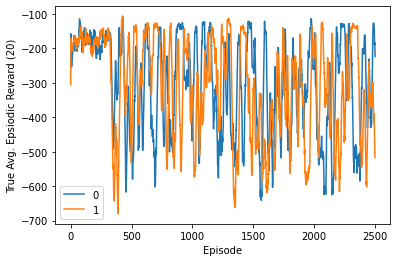

total time: 5641.124696969986 s


In [33]:
run(total_trials=2, total_episodes=2500, buffer_capacity=500000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=30000, continuous=False, std_dev=0.3)

In [ ]:
# run(total_trials=2, total_episodes=5000, start_steps=100000, continuous=True)

In [ ]:
#test(render=True, actor_weights='Weights/actor-trial1_LunarLander-v2_2500_50000_64_0.3_0.003_0.002_0.99_0.005_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_True_10000_-10.0_False_15.0_1.5_2022.8.1.8.55.0.h5', continuous=True, total_episodes=30)